<a href="https://colab.research.google.com/github/revak18/Science-Fair-2024/blob/main/PDSI_NBR_Data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Load Libraries

In [ ]:
import ee
ee.Authenticate()
ee.Initialize(project='210313089991')
import pandas as pd
import altair as alt
import numpy as np
import folium
import requests
import json
import geopandas as gpd
import seaborn as sns

# Load FTM Data Files

In [ ]:
## FTM Data: https://www.fs.usda.gov/rds/archive/catalog/RDS-2020-0001-2
## FTM Metadata: https://www.fs.usda.gov/rds/archive/products/RDS-2020-0001-2/_metadata_RDS-2020-0001-2.html

# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# File path in your Google Drive
file_path = '/content/drive/My Drive/FTM_fires.csv'

# Load FTM_fires.csv into Pandas DataFrame
df_FTM_fires = pd.read_csv(file_path)
print(df_FTM_fires.head(1))

# File path in your Google Drive
file_path = '/content/drive/My Drive/FTM_trees.csv'

# Load FTM_fires.csv into Pandas DataFrame
df_FTM_trees = pd.read_csv(file_path,low_memory=False)
print(df_FTM_trees.head(1))

Mounted at /content/drive
             YrFireName           Fire Dataset    N  yr_fire   Latitude  \
0  1981 - Manning Basin  Manning Basin   Brown  465     1981  42.602739   

    Longitude  Elevation  month_fire  day_fire Fire_type  State  \
0 -111.119003       2028         9.0      22.0        RX  Idaho   

     Sample_design Plot_size_ha   Threshold_diameter_cm  \
0  Fixed-area plot      0.01815  0 (every tree counted)   

                            Study_purpose  
0  Fuel Treatment Effects; Tree Mortality  
      YrFireName Species   Dataset  Times_burned   ID Plot TreeNum Unit Genus  \
0  2006 - Tripod   2TREE  Prichard             1  NaN  188      15  NaN   NaN   

  Species_name  ... IPS MPB  RPB  RTB  SB  WPB  WB  SPB  CVS_percent_source  \
0          NaN  ... NaN NaN  NaN  NaN NaN  NaN NaN  NaN                   F   

   CVK_percent_source  
0                 NaN  

[1 rows x 64 columns]


In [ ]:
df_FTM_fires = df_FTM_fires[['YrFireName', 'Fire', 'Dataset', 'yr_fire', 'Latitude','Longitude', 'Elevation', 'month_fire', 'day_fire', 'State']].copy()
#drop fires with no values for Latitude or Longitude
df_FTM_fires = df_FTM_fires[df_FTM_fires['Latitude'].notna()].copy()
df_FTM_fires = df_FTM_fires[df_FTM_fires['Longitude'].notna()].copy()
df_FTM_fires.shape

(427, 10)

In [ ]:
df_FTM_trees = df_FTM_trees[['YrFireName', 'Species', 'Dataset', 'yr0status', 'yr1status']].copy()

In [ ]:
df_FTM_FINAL = pd.merge(df_FTM_trees, df_FTM_fires, on=['YrFireName','Dataset'], how='left').copy()
df_FTM_FINAL.head()

,YrFireName,Species,Dataset,yr0status,yr1status,Fire,yr_fire,Latitude,Longitude,Elevation,month_fire,day_fire,State
0,2006 - Tripod,2TREE,Prichard,NaN,1.0,Tripod,2006.0,48.581953,-120.071814,1306.0,6.0,4.0,Washington
1,2006 - Tripod,2TREE,Prichard,NaN,1.0,Tripod,2006.0,48.581953,-120.071814,1306.0,6.0,4.0,Washington
2,2006 - Tripod,2TREE,Prichard,NaN,1.0,Tripod,2006.0,48.581953,-120.071814,1306.0,6.0,4.0,Washington
3,2006 - Tripod,2TREE,Prichard,NaN,1.0,Tripod,2006.0,48.581953,-120.071814,1306.0,6.0,4.0,Washington
4,2006 - Tripod,2TREE,Prichard,NaN,1.0,Tripod,2006.0,48.581953,-120.071814,1306.0,6.0,4.0,Washington


In [ ]:
df_FTM_FINAL = df_FTM_FINAL.drop_duplicates()
df_FTM_FINAL.shape
#(3194, 13)

(3194, 13)

In [ ]:
df_FTM_FINAL.head()

,YrFireName,Species,Dataset,yr0status,yr1status,Fire,yr_fire,Latitude,Longitude,Elevation,month_fire,day_fire,State
0,2006 - Tripod,2TREE,Prichard,NaN,1.0,Tripod,2006.0,48.581953,-120.071814,1306.0,6.0,4.0,Washington
64,2012 - Pole Creek,2TREE,Agne,NaN,1.0,Pole Creek,2012.0,44.177581,-121.676697,1506.0,9.0,9.0,Oregon
65,2013 - Westfork,2TREE,Andrus,NaN,1.0,Westfork,2013.0,37.551838,-106.872494,3521.0,6.0,5.0,Colorado
66,2008 - New Fork,2TREE,Harvey,NaN,NaN,New Fork,2008.0,43.091132,-109.917090,2619.0,NaN,NaN,Wyoming
69,2011 - Red Rock,2TREE,Harvey,NaN,1.0,Red Rock,2011.0,43.550948,-110.335573,2607.0,NaN,NaN,Wyoming


In [ ]:
df_FTM_FINAL.State.unique()

array(['Washington', 'Oregon', 'Colorado', 'Wyoming', 'Ohio', 'Alabama',
       'South Carolina', 'Arizona', 'California', 'New Mexico', nan,
       'Utah', 'Idaho', 'Montana', 'Arkansas', 'North Carolina',
       'Michigan', 'Florida', 'Alaska', 'Georgia', 'South Dakota',
       'Minnesota'], dtype=object)

In [ ]:
df_Map_Loc = df_FTM_FINAL[['Latitude','Longitude']].copy()
df_Map_Loc = df_Map_Loc.dropna()
df_Map_Loc = df_Map_Loc.drop_duplicates()
df_Map_Loc.head(2)

,Latitude,Longitude
0,48.581953,-120.071814
64,44.177581,-121.676697


In [ ]:
# Create a map centered at the US geographical coordinates with a satellite view

#map_us = folium.Map(location=[37.0902, -95.7129], width=1000,height=1000, zoom_start=4, tiles='https://server.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/tile/{z}/{y}/{x}', attr='Esri')
#map_us = folium.Map(location=[37.0902, -95.7129], width=1000,height=1000, zoom_start=4,tiles='stamenterrain')
map_us = folium.Map(location=[37.0902, -95.7129], width=1000,height=1000, zoom_start=4,tiles='CartoDB Positron')

# Add markers for each location in the DataFrame
for index, row in df_Map_Loc.iterrows():
    folium.CircleMarker([row['Latitude'], row['Longitude']],radius=3,fill=False,color='seagreen').add_to(map_us)

# Add US state boundaries using folium.Choropleth
folium.Choropleth(
    geo_data='https://raw.githubusercontent.com/python-visualization/folium/master/examples/data/us-states.json',
    fill_opacity=0,
    line_opacity=0.3,
).add_to(map_us)

# Display the map
map_us

In [ ]:
# Access the Feature Collection for burned area boundaries
burned_area_boundaries = ee.FeatureCollection('USFS/GTAC/MTBS/burned_area_boundaries/v1')

# Iterate through each coordinate in the DataFrame to get burned area boundaries
for index, row in df_Map_Loc.iterrows():
    # Create a buffer around the coordinate (e.g., 1 km radius)
    point = ee.Geometry.Point(row['Longitude'], row['Latitude'])
    region = point.buffer(1000)  # Adjust the buffer distance as needed

    # Filter burned area boundaries within the buffered region
    boundaries_within_region = burned_area_boundaries.filterBounds(region)

    # Convert burned area boundaries to GeoJSON format
    boundaries_geojson = boundaries_within_region.getInfo()

    # Add the burned area boundaries to the map_us
    folium.GeoJson(
        boundaries_geojson,
        name=f'Burned Area Boundaries - Point {index}',
        style_function=lambda x: {'color': 'red', 'weight': 2, 'opacity': 0.99, 'fillOpacity': 0}
    ).add_to(map_us)

    # Add a marker for the coordinate to the map
    folium.Marker([row['Latitude'], row['Longitude']]).add_to(map_us)

# Common Functions

In [ ]:
def create_reduce_region_function(geometry,
                                  reducer=ee.Reducer.mean(),
                                  scale=5000,
                                  crs='EPSG:4326',
                                  bestEffort=True,
                                  maxPixels=1e13,
                                  tileScale=4):
  def reduce_region_function(img):
    stat = img.reduceRegion(
        reducer=reducer,
        geometry=geometry,
        scale=scale,
        crs=crs,
        bestEffort=bestEffort,
        maxPixels=maxPixels,
        tileScale=tileScale)

    return ee.Feature(geometry, stat).set({'millis': img.date().millis()})
  return reduce_region_function

In [ ]:
# Define a function to transfer feature properties to a dictionary.
def fc_to_dict(fc):
  prop_names = fc.first().propertyNames()
  prop_lists = fc.reduceColumns(
      reducer=ee.Reducer.toList().repeat(prop_names.size()),
      selectors=prop_names).get('list')

  return ee.Dictionary.fromLists(prop_names, prop_lists)

In [ ]:
# Function to add date variables to DataFrame.
def add_date_info(df):
  df['Timestamp'] = pd.to_datetime(df['millis'], unit='ms')
  df['Year'] = pd.DatetimeIndex(df['Timestamp']).year
  df['Month'] = pd.DatetimeIndex(df['Timestamp']).month
  return df

# Collect PDSI from google earthe engine datasets

In [ ]:
def get_pdsi_collection(yr):
  fire_yr = ee.Date(pd.to_datetime(yr))
  ## -1 indicate previous year data and 3 indicates 3 years starting from year of Fire
  ## For example for Fire that happened in 2001, below statement would fetch data for 2000, 2001, 2002 & 2003
  date_range = ee.DateRange(fire_yr.advance(-1, 'years'), fire_yr.advance(3, 'years'))
  pdsi = ee.ImageCollection('GRIDMET/DROUGHT').filterDate(date_range).select('pdsi')
  return pdsi

In [ ]:
def get_pdsi(pdsi,aoi):
  reduce_pdsi = create_reduce_region_function(
    geometry=aoi, reducer=ee.Reducer.mean(), scale=5000, crs='EPSG:3310')

  pdsi_stat_fc = ee.FeatureCollection(pdsi.map(reduce_pdsi)).filter(
    ee.Filter.notNull(pdsi.first().bandNames()))

  pdsi_dict = fc_to_dict(pdsi_stat_fc).getInfo()
  pdsi_df = pd.DataFrame(pdsi_dict)
  pdsi_df = add_date_info(pdsi_df)
  pdsi_df = pdsi_df.rename(columns={
    'pdsi': 'PDSI'
  }).drop(columns=['millis', 'system:index'])
  return pdsi_df

In [ ]:
# Access the Feature Collection for burned area boundaries
burned_area_boundaries = ee.FeatureCollection('USFS/GTAC/MTBS/burned_area_boundaries/v1')

def check_existence(latitude, longitude, coordinates):
    return (latitude, longitude) in coordinates

def get_sample_points(boundaries_within_region):
    random_points = ee.FeatureCollection.randomPoints(
    region=boundaries_within_region, points=10, seed=0, maxError=1)
    #print(random_points.geometry().coordinates().getInfo())
    return random_points.geometry().coordinates().getInfo()


coordinates_list  = []
for index, row in df_FTM_fires.iterrows():
    # Create a buffer around the coordinate (e.g., 1 km radius)
    print('index:', index, '::', row['YrFireName'], row['State'], row['Longitude'], row['Latitude'])
    point = ee.Geometry.Point(row['Longitude'], row['Latitude'])

    if check_existence(row['Latitude'], row['Longitude'], coordinates_list):
        print(row['Latitude'], ' ', row['Longitude'], ' exists in the list.')
    elif index < 393:
        print('index:', index)
    #elif row['YrFireName'] == '2010 - Gilles Creek':
    #    print('skipping....')
    #    print(row['YrFireName'])
    else:
        #fr = str(row['YrFireName'])
        flag = False
        N = 1000
        while flag is False:
          region = point.buffer(N)  # Adjust the buffer distance as needed
          boundaries_within_region = burned_area_boundaries.filterBounds(region)
          collection_size = boundaries_within_region.size().getInfo()
          if collection_size == 0:
            N = N + 1000
            print('N:', N)
          else:
            #aoi = boundaries_within_region.geometry()
            yr = str(int(row['yr_fire']))
            pt_dict = get_sample_points(boundaries_within_region)
            df_sample = pd.DataFrame(pt_dict)
            df_sample.columns = ['Longitude', 'Latitude']
            df_sample['YrFireName'] = row['YrFireName']
            df_sample['Dataset'] = row['Dataset']
            df_sample['yr_fire'] = row['yr_fire']
            for index, row in df_sample.iterrows():
              #print(row['Longitude'],row['Latitude'])
              sample_point = ee.Geometry.Point(row['Longitude'], row['Latitude'])
              pdsi = get_pdsi_collection(yr)
              pdsi_df = get_pdsi(pdsi,sample_point)
              pdsi_df['YrFireName'] = row['YrFireName']
              pdsi_df['Dataset'] = row['Dataset']
              pdsi_df['yr_fire'] = row['yr_fire']
              pdsi_df['Longitude'] = row['Longitude']
              pdsi_df['Latitude'] = row['Latitude']
              frnm = str(row['YrFireName'])
              frnm = frnm.replace("/","")
              file_path = '/content/drive/My Drive/PDSI_FINAL/1_PDSI_' + str(index) + '_' + frnm + '.csv'
              pdsi_df.to_csv(file_path, index=False)
              coordinates_list.append((row['Latitude'],row['Longitude']))
              flag = True

index: 0 :: 1981 - Manning Basin Idaho -111.119003 42.602739
index: 0
index: 1 :: 1981 - Snowdrift Idaho -111.226913 42.549037
index: 1
index: 2 :: 1981 - Steep Creek Wyoming -110.556666 42.272226
index: 2
index: 3 :: 1982 - SEKI 69 or 74 Reburn California -118.92054 36.706663
index: 3
index: 4 :: 1983 - Oops Idaho -116.752536 48.359752
index: 4
index: 5 :: 1983 - Upper Priest Idaho -116.751443 48.359561
index: 5
index: 6 :: 1984 - Lower Priest Idaho -116.751443 48.359561
index: 6
index: 7 :: 1986 - SEKI Muir PNF California -118.8385 36.634222
index: 7
index: 8 :: 1987 - SEKI Pierce W California -118.935951 36.676244
index: 8
index: 9 :: 1988 - Air Patrol Montana -106.586448 45.50256
index: 9
index: 10 :: 1988 - Brewer Montana -104.169324 45.635843
index: 10
index: 11 :: 1988 - Canyon Creek Montana -111.792756 46.43917
index: 11
index: 12 :: 1988 - Earlybird Montana -106.513703 45.665263
index: 12
index: 13 :: 1988 - Greater Yellowstone Ecosystem Wyoming -110.55852 44.193531
index: 13


# Load PDSI Data from files for processing

In [ ]:
import os
import regex as re
# Define the folder path in your Google Drive where your files are stored
folder_path = '/content/drive/My Drive/PDSI_FINAL'

# List files in the folder that start with a certain string
file_list = [file for file in os.listdir(folder_path) if file.startswith('1_PDSI_')]
#file_list=[]
#pattern = re.compile(r'2007')
#for file in os.listdir(folder_path):
#  if pattern.search(file):
#    file_list.append(file)


# Read all files into a Pandas DataFrame
dfs = []
i=1
for file_name in file_list:
    print(i,'..',file_name)
    file_path = os.path.join(folder_path, file_name)
    # Assuming files are CSV, change the read function accordingly for other formats
    df = pd.read_csv(file_path)
    dfs.append(df)
    i+=1

# Concatenate all DataFrames
pdsi_combined_df = pd.concat(dfs, ignore_index=True)

# Display combined DataFrame
print(pdsi_combined_df.shape)
#(1223480, 9)

In [ ]:
bkup_pdsi = pdsi_combined_df.copy()

In [ ]:
pdsi_combined_df['uid'] = ((pdsi_combined_df['Latitude'] * 100000000) % 100000000).astype(int)
pdsi_combined_df.sample(5)
#pdsi_combined_df[pdsi_combined_df['YrFireName']=='1988 - Earlybird'].sample(50)

,PDSI,Timestamp,Year,Month,YrFireName,Dataset,yr_fire,Longitude,Latitude,uid
1195146,-1.74,1994-11-16 06:00:00,1994,11,1992 - Slowey,Hood,1992,-114.914452,47.250272,25027192
87571,0.07,2010-08-13 06:00:00,2010,8,2008 - Mineral Ecosystem Management Area,Roccaforte,2008,-109.649597,34.182894,18289356
1022723,-1.19,1999-12-01 06:00:00,1999,12,1999 - ZION Northgate Peaks,NPS,1999,-113.102204,37.341940,34194033
393666,3.47,2003-09-12 06:00:00,2003,9,2004 - Southeastern Piedmont Clemson SC 71,McIver,2004,-83.072410,34.903708,90370804
668453,-2.99,2001-11-26 06:00:00,2001,11,2002 - Crater-FB-R,Perrakis,2002,-122.309324,42.801417,80141659


In [ ]:
pdsi_combined_df.groupby(['uid','Year']).count()

In [ ]:
pdsi_combined_df[(pdsi_combined_df['YrFireName']=='2016 - Paradise 90') & (pdsi_combined_df['Year']==2018) & (pdsi_combined_df['Month']==12)].shape

(70, 10)

In [ ]:
#pdsi_combined_df.groupby(['YrFireName']).count() #419 rows, each with 2920
#pdsi_combined_df.groupby(['YrFireName','uid']).count() #4190 rows each with 292...10 uids per fire...419x10
#pdsi_combined_df.groupby(['YrFireName','uid','Year']).count() #16760 rows...73 per month
#pdsi_combined_df.groupby(['YrFireName','uid','Year','Month']).count() # 201120 row...each month has 6 row except Dec where there are 7 rows
#pdsi_combined_df.groupby(['uid','YrFireName']).count()
pdsi_combined_df.groupby(['uid']).count() # 2207 rows deleted #1994 - GRCA Picnic, 2000 - GRCA Picnic # 1997 - GRCA Watson

In [ ]:
pdsi_combined_df[pdsi_combined_df['uid']==99910221].sample(15)
#2009 - GRCA Picnic
#1994 - GRCA Picnic
#2000 - GRCA Picnic

In [ ]:
## Get rid of duplicates. These fires occured at same place few years apart
##Set 1
idx = pdsi_combined_df[(pdsi_combined_df['uid']==99958864) & (pdsi_combined_df['YrFireName']=='1997 - GRCA Watson')].index
idx
pdsi_combined_df.drop(idx , inplace=True)

##Set 2
idx = pdsi_combined_df[(pdsi_combined_df['uid']==99910221) & (pdsi_combined_df['YrFireName']=='1994 - GRCA Picnic')].index
idx
pdsi_combined_df.drop(idx , inplace=True)

idx = pdsi_combined_df[(pdsi_combined_df['uid']==99910221) & (pdsi_combined_df['YrFireName']=='2000 - GRCA Picnic')].index
idx
pdsi_combined_df.drop(idx , inplace=True)

In [ ]:
split_dataframes = {category: group for category, group in pdsi_combined_df.groupby('uid')}
#2207 items

In [ ]:
list(split_dataframes.values())[2206]

In [ ]:
len_split = len(split_dataframes)
i=0
pdsi_list=[]
while i < len_split:
  print(i)
  df = list(split_dataframes.values())[i]
  df['Date'] = pd.to_datetime(df['Timestamp'],format='%Y-%m-%d').dt.date
  df.index = pd.DatetimeIndex(df["Date"])
  df = df.sort_index()
  rolling_mean_2YR = df['PDSI'].rolling(window='730D',min_periods=1).mean() ##<<---------730D = 2yr Rolling mean #RF Accuracy 94.8  (Long-Term Seasonality - longer-term patterns)
  rolling_mean_6MO = df['PDSI'].rolling(window='180D',min_periods=1).mean() ##<<---------180D = 6mo Rolling mean #RF Accuracy ????? (Medium-Term Seasonality - quarterly variations)
  df['Rolling_Mean_2YR'] = rolling_mean_2YR
  df['Rolling_Mean_6MO'] = rolling_mean_6MO
  pdsi_list.append(df)
  i+=1
df_pdsi = pd.concat(pdsi_list)

<Axes: xlabel='Date'>

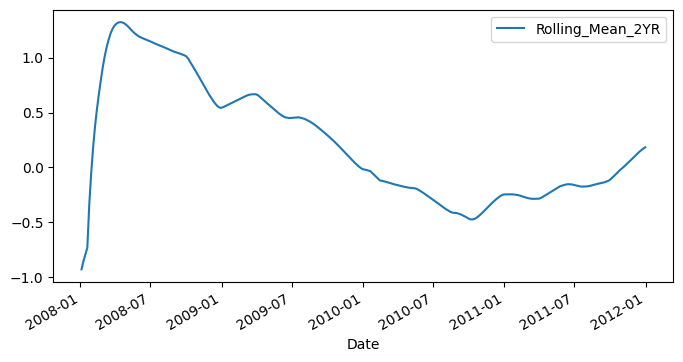

In [ ]:
dd = df_pdsi[df_pdsi['uid']==99910221].dropna(subset=['Rolling_Mean_2YR'])[['Timestamp','Rolling_Mean_2YR']].copy()
dd.plot(figsize=(8, 4))

<Axes: xlabel='Date'>

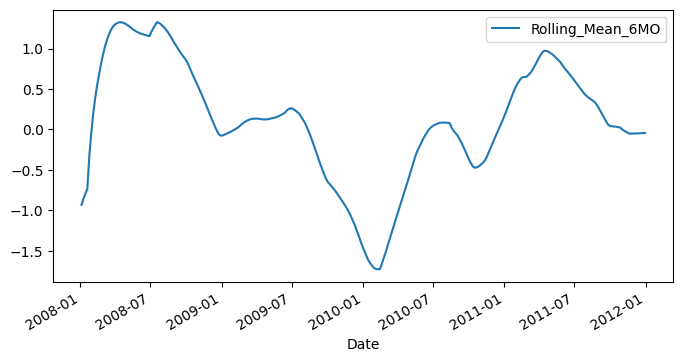

In [ ]:
dd = df_pdsi[df_pdsi['uid']==99910221].dropna(subset=['Rolling_Mean_6MO'])[['Timestamp','Rolling_Mean_6MO']].copy()
dd.plot(figsize=(8, 4))

**annual_average_2years**

In [ ]:
annual_average_2years = df_pdsi.groupby(['YrFireName','Dataset','uid']).resample('Y')['Rolling_Mean_2YR'].mean().reset_index()
tmp = pd.DataFrame(annual_average_2years)
tmp = tmp.rename(columns={"Rolling_Mean_2YR": "Annual_Average_2Years"})
tmp = tmp.sort_values(by=['YrFireName','Dataset','uid','Date'])
tmp['tmpkey'] = tmp['YrFireName'] + str(':') + tmp['Dataset'] + str(':') + tmp['uid'].astype(str)
tmp ##16748 rows × 6 columns

,YrFireName,Dataset,uid,Date,Annual_Average_2Years,tmpkey
0,1981 - Manning Basin,Brown,47149889,1980-12-31,1.180234,1981 - Manning Basin:Brown:47149889
1,1981 - Manning Basin,Brown,47149889,1981-12-31,0.458055,1981 - Manning Basin:Brown:47149889
2,1981 - Manning Basin,Brown,47149889,1982-12-31,-0.046168,1981 - Manning Basin:Brown:47149889
3,1981 - Manning Basin,Brown,47149889,1983-12-31,2.238681,1981 - Manning Basin:Brown:47149889
4,1981 - Manning Basin,Brown,47368165,1980-12-31,1.180234,1981 - Manning Basin:Brown:47368165
...,...,...,...,...,...,...
16743,2016 - Paradise 90,FERA,57869346,2018-12-31,1.289865,2016 - Paradise 90:FERA:57869346
16744,2016 - Paradise 90,FERA,60711538,2015-12-31,-0.389008,2016 - Paradise 90:FERA:60711538
16745,2016 - Paradise 90,FERA,60711538,2016-12-31,-1.845894,2016 - Paradise 90:FERA:60711538
16746,2016 - Paradise 90,FERA,60711538,2017-12-31,-0.574092,2016 - Paradise 90:FERA:60711538


In [ ]:
#create unique list of names
UniqueNames = tmp.tmpkey.unique()

#create a data frame dictionary to store your data frames
DataFrameDict = {elem : pd.DataFrame() for elem in UniqueNames}

for key in DataFrameDict.keys():
    DataFrameDict[key] = tmp[:][tmp.tmpkey == key]
DataFrameDict

In [ ]:
df_pdsi_bkup = df_pdsi.copy()
tmp_pdsi_annual_avg_lst=[]
i=0
for key in DataFrameDict.keys():
  print('key: ', key)
  tmpDFD=DataFrameDict[key]

  pivot = pd.pivot_table(tmpDFD, values='Annual_Average_2Years',
                                index=['YrFireName', 'Dataset','uid'],
                                columns=['Date'])

  namesList = ['PrevYr_PDSI','Yr0_PDSI','Yr1_PDSI','Yr2_PDSI']
  pivot.columns = pivot.columns[:0].tolist() + namesList
  pivot.reset_index(inplace=True)
  tmp_FTMFINAL_pivot = pd.merge(df_pdsi,pivot,on=['YrFireName','Dataset','uid'], how='inner').copy()
  tmp_pdsi_annual_avg_lst.append(tmp_FTMFINAL_pivot)

df_FTM_pdsi_annual_avg=pd.concat(tmp_pdsi_annual_avg_lst)

In [ ]:
file_path = '/content/drive/My Drive/df_FTM_pdsi_nbr_annual_avg.csv'
df_FTM_pdsi_annual_avg.to_csv(file_path, index=False)

**annual_average_6months**

In [ ]:
annual_average_6months = df_pdsi.groupby(['YrFireName','Dataset','uid']).resample('180D')['Rolling_Mean_6MO'].mean().reset_index()
tmp = pd.DataFrame(annual_average_6months)
tmp = tmp.rename(columns={"Rolling_Mean_6MO": "Average_6Months"})
tmp = tmp.sort_values(by=['YrFireName','Dataset','uid','Date'])
tmp['tmpkey'] = tmp['YrFireName'] + str(':') + tmp['Dataset'] + str(':') + tmp['uid'].astype(str)
tmp ##16748 rows × 6 columns

In [ ]:
#create unique list of names
UniqueNames = tmp.tmpkey.unique()

#create a data frame dictionary to store your data frames
DataFrameDict = {elem : pd.DataFrame() for elem in UniqueNames}

for key in DataFrameDict.keys():
    DataFrameDict[key] = tmp[:][tmp.tmpkey == key]
DataFrameDict

In [ ]:
df_pdsi_bkup = df_pdsi.copy()
tmp_pdsi_6month_avg_lst=[]
i=0
for key in DataFrameDict.keys():
  print('key: ', key)
  tmpDFD=DataFrameDict[key]

  pivot = pd.pivot_table(tmpDFD, values='Average_6Months',
                                index=['YrFireName', 'Dataset','uid'],
                                columns=['Date'])

  namesList = ['PrevYr_H1','PrevYr_H2','Yr0_H1','Yr0_H2','Yr1_H1','Yr1_H2','Yr2_H1','Yr2_H2','IGNORE']
  pivot.columns = pivot.columns[:0].tolist() + namesList
  pivot.reset_index(inplace=True)
  tmp_FTMFINAL_pivot = pd.merge(df_pdsi,pivot,on=['YrFireName','Dataset','uid'], how='inner').copy()
  tmp_pdsi_6month_avg_lst.append(tmp_FTMFINAL_pivot)

df_FTM_pdsi_6month_avg=pd.concat(tmp_pdsi_6month_avg_lst)

In [ ]:
file_path = '/content/drive/My Drive/df_FTM_pdsi_6month_avg.csv'
df_FTM_pdsi_6month_avg.to_csv(file_path, index=False)

In [ ]:
df_FTM_pdsi_6month_avg.sample(5)

,PDSI,Timestamp,Year,Month,YrFireName,Dataset,yr_fire,Longitude,Latitude,uid,...,Rolling_Mean_6MO,PrevYr_H1,PrevYr_H2,Yr0_H1,Yr0_H2,Yr1_H1,Yr1_H2,Yr2_H1,Yr2_H2,IGNORE
56,3.54,1997-10-12 06:00:00,1997,10,1998 - BRCA Residential,NPS,1998,-112.195139,37.644462,64446201,...,0.796111,-1.321439,0.635610,2.677986,3.055324,3.166898,1.358889,-0.569074,-1.688009,-1.172986
268,3.74,1995-09-07 06:00:00,1995,9,1993 - GRCA Northwest 3,NPS,1993,-112.285646,36.330388,33038777,...,4.193889,0.416673,2.554174,3.732924,4.973387,2.713009,0.676682,0.719745,3.834298,3.435347
255,-1.50,1991-07-04 06:00:00,1991,7,1989 - SEKI Crystal,NPS,1989,-118.769391,36.492326,49232628,...,-2.097746,-1.528184,-1.296238,-0.970662,-1.160778,-0.777309,-1.854252,-2.350701,-1.666840,-1.409013
51,-0.03,2001-09-17 06:00:00,2001,9,2002 - SEKI Highway,NPS,2002,-118.835785,36.635283,63528326,...,-0.317398,-0.329279,-0.369398,0.026276,-1.198990,-0.107857,1.272439,0.528450,-1.754058,-1.426138
94,-2.83,2015-04-20 06:00:00,2015,4,2015 - Wooded Hills,Coleman,2015,-116.391320,32.860843,86084277,...,-2.041389,-0.776752,-2.047677,-1.983133,0.137955,1.975918,-0.242685,-0.455633,-0.547508,-1.297708


In [ ]:
df_FTM_pdsi_annual_avg.sample(5)

,PDSI,Timestamp,Year,Month,YrFireName,Dataset,yr_fire,Longitude,Latitude,uid,Date,Rolling_Mean_2YR,Rolling_Mean_6MO,PrevYr_PDSI,Yr0_PDSI,Yr1_PDSI,Yr2_PDSI
65,-1.09,2007-11-26 06:00:00,2007,11,2008 - WHIS Sunshine,NPS,2008,-122.703103,40.504773,50477265,2007-11-26,-1.973664,-1.919577,-1.982681,-1.949142,-2.252019,-1.464628
9,1.93,2007-02-19 06:00:00,2007,2,2008 - ELMA Agua Fria,NPS,2008,-108.060794,34.959708,95970789,2007-02-19,0.079855,2.105333,-0.063659,0.692204,0.055068,-0.605815
120,-2.23,2003-08-28 06:00:00,2003,8,2003 - Southwestern Plateau Northern Arizona 149,McIver,2003,-112.079273,35.002140,213977,2003-08-28,-2.941535,-2.037606,-2.776369,-3.044404,-2.456923,-0.266324
72,-2.59,2001-12-31 06:00:00,2001,12,2002 - Cone,Hood,2002,-121.165607,40.758271,75827058,2001-12-31,-3.032192,-3.530556,-2.446037,-2.974292,-2.558392,-1.065028
28,-3.00,1996-05-24 06:00:00,1996,5,1997 - BAND 49,NPS,1997,-106.433009,35.934950,93494995,1996-05-24,2.277750,-0.519906,1.995936,0.679012,1.192049,1.338594


In [ ]:
df_FTM_pdsi_annual_avg.groupby(['YrFireName','uid']).count()

PDSI  Timestamp  Year  Month  Dataset  yr_fire  \
YrFireName           uid                                                        
1981 - Manning Basin 47149889   292        292   292    292      292      292   
                     47368165   292        292   292    292      292      292   
                     48201734   292        292   292    292      292      292   
                     48621235   292        292   292    292      292      292   
                     49138332   292        292   292    292      292      292   
...                             ...        ...   ...    ...      ...      ...   
2016 - Paradise 90   53012200   292        292   292    292      292      292   
                     55322292   292        292   292    292      292      292   
                     56965555   292        292   292    292      292      292   
                     57869346   292        292   292    292      292      292   
                     60711538   292        292   292    292      292      292   

                               Longitude  Latitude  Date  Rolling_Mean_2YR  \
YrFireName           uid                                                     
1981 - Manning Basin 47149889        292       292   292               292   
                     47368165        292       292   292               292   
                     48201734        292       292   292               292   
                     48621235        292       292   292               292   
                     49138332        292       292   292               292   
...                                  ...       ...   ...               ...   
2016 - Paradise 90   53012200        292       292   292               292   
                     55322292        292       292   292               292   
                     56965555        292       292   292               292   
                     57869346        292       292   292               292   
                     60711538        292       292   292               292   

                               PrevYr_PDSI  Yr0_PDSI  Yr1_PDSI  Yr2_PDSI  
YrFireName           uid                                                  
1981 - Manning Basin 47149889          292       292       292       292  
                     47368165          292       292       292       292  
                     48201734          292       292       292       292  
                     48621235          292       292       292       292  
                     49138332          292       292       292       292  
...                                    ...       ...       ...       ...  
2016 - Paradise 90   53012200          292       292       292       292  
                     55322292          292       292       292       292  
                     56965555          292       292       292       292  
                     57869346          292       292       292       292  
                     60711538          292       292       292       292  

[4187 rows x 14 columns]

In [ ]:
PDSI_TMP = df_FTM_pdsi_annual_avg[['YrFireName','Dataset','uid','yr_fire','Longitude','Latitude','PrevYr_PDSI','Yr0_PDSI','Yr1_PDSI','Yr2_PDSI']].copy()
PDSI_TMP = PDSI_TMP.drop_duplicates()
del df_FTM_pdsi_annual_avg

In [ ]:
PDSI_TMP_2 = df_FTM_pdsi_6month_avg[['YrFireName','Dataset','uid','PrevYr_H1','PrevYr_H2','Yr0_H1','Yr0_H2','Yr1_H1','Yr1_H2','Yr2_H1','Yr2_H2']].copy()
PDSI_TMP_2 = PDSI_TMP_2.drop_duplicates()
del df_FTM_pdsi_6month_avg

In [ ]:
df_FTM_pdsi_all = PDSI_TMP.merge(PDSI_TMP_2, on=['YrFireName','Dataset','uid'])
file_path = '/content/drive/My Drive/df_FTM_pdsi_all.csv'
df_FTM_pdsi_all.to_csv(file_path, index=False)

In [ ]:
df_FTM_pdsi_all

,YrFireName,Dataset,uid,yr_fire,Longitude,Latitude,PrevYr_PDSI,Yr0_PDSI,Yr1_PDSI,Yr2_PDSI,PrevYr_H1,PrevYr_H2,Yr0_H1,Yr0_H2,Yr1_H1,Yr1_H2,Yr2_H1,Yr2_H2
0,1981 - Manning Basin,Brown,47149889,1981,-111.048065,42.471499,1.180234,0.458055,-0.046168,2.238681,0.667431,2.139102,-0.100653,-2.714655,-0.316536,3.359708,4.265538,4.997919
1,1981 - Manning Basin,Brown,47368165,1981,-111.053830,42.473682,1.180234,0.458055,-0.046168,2.238681,0.667431,2.139102,-0.100653,-2.714655,-0.316536,3.359708,4.265538,4.997919
2,1981 - Manning Basin,Brown,48201734,1981,-111.055792,42.482017,0.998056,0.077613,-0.285857,2.088259,0.630768,1.671135,-0.636127,-2.911414,-0.252647,3.229230,3.983146,4.726618
3,1981 - Manning Basin,Brown,48621235,1981,-111.065309,42.486212,0.998056,0.077613,-0.285857,2.088259,0.630768,1.671135,-0.636127,-2.911414,-0.252647,3.229230,3.983146,4.726618
4,1981 - Manning Basin,Brown,49138332,1981,-111.074620,42.491383,0.933905,0.011721,-0.282480,2.117834,0.587984,1.573487,-0.742034,-2.820866,-0.163785,3.204255,4.007635,4.709539
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4182,2016 - Paradise 90,FERA,53012200,2016,-118.482565,48.530122,-0.415112,-1.723457,-0.313089,1.303536,0.419930,-2.073349,-2.486281,-1.496451,1.954722,3.159059,0.760556,0.298912
4183,2016 - Paradise 90,FERA,55322292,2016,-118.534785,48.553223,-0.415112,-1.723457,-0.313089,1.303536,0.419930,-2.073349,-2.486281,-1.496451,1.954722,3.159059,0.760556,0.298912
4184,2016 - Paradise 90,FERA,56965555,2016,-118.470455,48.569656,-0.486969,-1.578655,-0.082866,1.615859,0.387464,-2.202161,-2.155478,-0.880262,2.087485,3.009012,1.264923,1.135856
4185,2016 - Paradise 90,FERA,57869346,2016,-118.540975,48.578693,-0.341641,-1.654256,-0.246071,1.289865,0.506717,-2.025015,-2.406335,-1.420108,2.025455,3.199144,0.586042,0.266188


In [ ]:
'''
# Calculating a 90-day rolling mean
pdsi_combined_df['Date'] = pd.to_datetime(pdsi_combined_df['Timestamp'],format='%Y-%m-%d').dt.date
pdsi_combined_df.index = pd.DatetimeIndex(pdsi_combined_df["Date"])
pdsi_combined_df = pdsi_combined_df.sort_index()

rolling_mean = pdsi_combined_df['PDSI'].rolling(window='730D',min_periods=1).mean()
# Adding the rolling mean as a new column in the DataFrame
pdsi_combined_df['Rolling_Mean_2YR'] = rolling_mean
#pdsi_combined_df.head()
'''

In [ ]:
'''
annual_average_2years = pdsi_combined_df.groupby(['YrFireName','Dataset','uid']).resample('Y')['Rolling_Mean_2YR'].mean().reset_index()
tmp = pd.DataFrame(annual_average_2years)
tmp = tmp.rename(columns={"Rolling_Mean_2YR": "Annual_Average_2Years"})
tmp = tmp.sort_values(by=['YrFireName','Dataset','uid','Date'])
tmp['tmpkey'] = tmp['YrFireName'] + str(':') + tmp['Dataset'] + str(':') + tmp['uid'].astype(str)
tmp
'''

In [ ]:
'''
#create unique list of names
UniqueNames = tmp.tmpkey.unique()

#create a data frame dictionary to store your data frames
DataFrameDict = {elem : pd.DataFrame() for elem in UniqueNames}

for key in DataFrameDict.keys():
    DataFrameDict[key] = tmp[:][tmp.tmpkey == key]
DataFrameDict
'''

In [ ]:
'''
tmp_pdsi_annual_avg_lst=[]
for key in DataFrameDict.keys():
  tmpDFD=DataFrameDict[key]

  pivot = pd.pivot_table(tmpDFD, values='Annual_Average_2Years',
                                index=['YrFireName', 'Dataset','uid'],
                                columns=['Date'])

  namesList = ['PrevYr_PDSI','Yr0_PDSI','Yr1_PDSI','Yr2_PDSI']
  pivot.columns = pivot.columns[:0].tolist() + namesList
  pivot.reset_index(inplace=True)
  #print(pivot)
  #print('-------------------------')
  tmp_FTMFINAL_pivot = pd.merge(pdsi_combined_df,pivot,on=['YrFireName','Dataset','uid'], how='inner').copy()
  tmp_pdsi_annual_avg_lst.append(tmp_FTMFINAL_pivot)

df_FTM_pdsi_annual_avg=pd.concat(tmp_pdsi_annual_avg_lst)
'''

# Collect NBR from google earthe engine datasets

In [ ]:
import pandas as pd
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

file_path = '/content/drive/My Drive/df_FTM_pdsi_nbr_annual_avg.csv'
df_FTM_pdsi_nbr_annual_avg = pd.read_csv(file_path)
df_FTM_pdsi_nbr_annual_avg.sample(5)

In [ ]:
'''
#################################################################
## Landsat Collection 1 to Collection 2 migration
## https://developers.google.com/earth-engine/landsat_c1_to_c2
## Surface reflectance
## 1) oli: LANDSAT/LC08/C01/T1_SR --> LANDSAT/LC08/C02/T1_L2
## A) image.select('B5') --> image.select('SR_B5')
## B) new scaling factors: Collection 1 used a 0.0001 scale factor. Collection 2 uses a 2.75e-05 scale factor and -0.2 offset
##  def apply_scale_factors(image):
##    optical_bands = image.select('SR_B.').multiply(0.0000275).add(-0.2)
##    thermal_band = image.select('ST_B6').multiply(0.00341802).add(149.0)
##    return image.addBands(optical_bands, None, True).addBands(thermal_band, None, True)
##  sr_col_scaled = sr_col.map(apply_scale_factors)
## C) QA masking: qa_mask = image.select('QA_PIXEL').bitwiseAnd(int('11111', 2)).eq(0)
##
## 2) etm: LANDSAT/LE07/C01/T1_SR	--> LANDSAT/LE07/C02/T1_L2
## A) image.select('B4') --> image.select('SR_B4')
## B)
##  def apply_scale_factors(image):
##    optical_bands = image.select('SR_B.').multiply(0.0000275).add(-0.2)
##    thermal_band = image.select('ST_B6').multiply(0.00341802).add(149.0)
##    return image.addBands(optical_bands, None, True).addBands(thermal_band, None, True)
##  sr_col_scaled = sr_col.map(apply_scale_factors)
## C) QA masking: qa_mask = image.select('QA_PIXEL').bitwiseAnd(int('11111', 2)).eq(0)
##
## 3) tm: LANDSAT/LT05/C01/T1_SR	--> LANDSAT/LT05/C02/T1_L2
## A) image.select('B4')	--> image.select('SR_B4')
## B) def apply_scale_factors(image):
##      optical_bands = image.select('SR_B.').multiply(0.0000275).add(-0.2)
##      thermal_band = image.select('ST_B6').multiply(0.00341802).add(149.0)
##      return image.addBands(optical_bands, None, True).addBands(thermal_band, None, True)
##    sr_col_scaled = sr_col.map(apply_scale_factors)
## C) QA masking: qa_mask = image.select('QA_PIXEL').bitwiseAnd(int('11111', 2)).eq(0)
#################################################################
def get_oli_col(aoi,date_range):
    print('in get_oli_col...')
    oli_col = (ee.ImageCollection('LANDSAT/LC08/C02/T1_L2')
              .filterBounds(aoi)
              .filterDate(date_range)
              .map(prep_oli))
    return oli_col

def get_etm_col(aoi,date_range):
    print('in get_etm_col...')
    etm_col = (ee.ImageCollection('LANDSAT/LE07/C02/T1_L2')
              .filterBounds(aoi)
              .filterDate(date_range)
              .map(prep_etm))
    return etm_col

def get_tm_col(aoi,date_range):
    print('in get_tm_col...')
    tm_col = (ee.ImageCollection('LANDSAT/LT05/C02/T1_L2')
              .filterBounds(aoi)
              .filterDate(date_range)
              .map(prep_etm))
    return tm_col

def rename_oli(img):
  return (img.select(
      ee.List(['SR_B2', 'SR_B3', 'SR_B4', 'SR_B5', 'SR_B6', 'SR_B7', 'QA_PIXEL']),
      ee.List(['Blue', 'Green', 'Red', 'NIR', 'SWIR1', 'SWIR2', 'QA_PIXEL'])))

# Define a function to get and rename bands of interest from ETM+.
def rename_etm(img):
  return (img.select(
      ee.List(['SR_B1', 'SR_B2', 'SR_B3', 'SR_B4', 'SR_B5', 'SR_B7', 'QA_PIXEL']),
      ee.List(['Blue', 'Green', 'Red', 'NIR', 'SWIR1', 'SWIR2', 'QA_PIXEL'])))


# Function to mask out clouds and cloud shadows
def cfmask(img):
    cloud_shadow_bi_mask = 1 << 3
    cloud_bit_mask = 1 << 5
    qa_mask = img.select('QA_PIXEL').bitwiseAnd(int('11010', 2)).eq(0)
    return img.updateMask(qa_mask)
    '''

In [ ]:
#############################################################################
## The below code block is Landsat Collection 1.
#############################################################################

def rename_oli(img):
  return (img.select(
      ee.List(['B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'pixel_qa']),
      ee.List(['Blue', 'Green', 'Red', 'NIR', 'SWIR1', 'SWIR2', 'pixel_qa'])))

# Define a function to get and rename bands of interest from ETM+.
def rename_etm(img):
  return (img.select(
      ee.List(['B1', 'B2', 'B3', 'B4', 'B5', 'B7', 'pixel_qa']),
      ee.List(['Blue', 'Green', 'Red', 'NIR', 'SWIR1', 'SWIR2', 'pixel_qa'])))

# Function to mask out clouds and cloud shadows
## The C Function of Mask (CFMask) algorithm populates cloud, cloud confidence, cloud shadow, and snow/ice pixels
## in the processing of Landsat Level-1 data products, with the results represented as bit-mapped values within
## the Landsat Collection 1 Level-1 Quality Assessment (QA) Band.
## https://www.usgs.gov/landsat-missions/cfmask-algorithm
def cfmask(img):
    cloud_shadow_bi_mask = 1 << 3
    cloud_bit_mask = 1 << 5
    qa = img.select('pixel_qa')
    mask = qa.bitwiseAnd(cloud_shadow_bi_mask).eq(0).And(
        qa.bitwiseAnd(cloud_bit_mask).eq(0))
    return img.updateMask(mask)

## OLI (Landsat's Operational Land Imager sensor)
## OLI measures in the visible, near infrared, and shortwave infrared portions (VNIR, NIR, and SWIR) of the spectrum.
## https://www.usgs.gov/landsat-missions/landsat-8?qt-science_support_page_related_con=0#qt-science_support_page_related_con
#https://developers.google.com/earth-engine/datasets/catalog/LANDSAT_LC08_C01_T1_SR (Depricated)
#https://developers.google.com/earth-engine/datasets/catalog/LANDSAT_LC08_C02_T1_L2 (superseded by)
def get_oli_col(aoi,date_range):
    print('in get_oli_col...')
    oli_col = (ee.ImageCollection('LANDSAT/LC08/C01/T1_SR')
              .filterBounds(aoi)
              .filterDate(date_range)
              .map(prep_oli))
    return oli_col

## ETM+ (Landsat's Enhanced Thematic Mapper Plus sensor)
## The ETM+ contains eight spectral bands, including a pan and thermal band:
## Band 1 Blue (0.45 - 0.52 µm) 30 m | Band 2 Green (0.52 - 0.60 µm) 30 m | Band 3 Red (0.63 - 0.69 µm) 30 m
## Band 4 Near-Infrared (0.77 - 0.90 µm) 30 m | Band 5 Short-wave Infrared (1.55 - 1.75 µm) 30 m | Band 6 Thermal (10.40 - 12.50 µm) 60 m Low Gain / High Gain
## Band 7 Mid-Infrared (2.08 - 2.35 µm) 30 m | Band 8 Panchromatic (PAN) (0.52 - 0.90 µm) 15 m
## https://www.usgs.gov/landsat-missions/landsat-7?qt-science_support_page_related_con=0#qt-science_support_page_related_con
#https://developers.google.com/earth-engine/datasets/catalog/LANDSAT_LE07_C01_T1_SR (Depricated)
#https://developers.google.com/earth-engine/datasets/catalog/LANDSAT_LE07_C02_T1_L2 (superseded by)
def get_etm_col(aoi,date_range):
    print('in get_etm_col...')
    etm_col = (ee.ImageCollection('LANDSAT/LE07/C01/T1_SR')
              .filterBounds(aoi)
              .filterDate(date_range)
              .map(prep_etm))
    return etm_col

## TM (Landsat's Thematic Mapper sensor)
## Seven spectral bands, including a thermal band:
## Band 1 Visible Blue (0.45 - 0.52 µm) 30 m | Band 2 Visible Green (0.52 - 0.60 µm) 30 m | Band 3 Visible Red (0.63 - 0.69 µm) 30 m
## Band 4 Near-Infrared (0.76 - 0.90 µm) 30 m | Band 5 Near-Infrared (1.55 - 1.75 µm) 30 m | Band 6 Thermal (10.40 - 12.50 µm) 120 m
## Band 7 Mid-Infrared (2.08 - 2.35 µm) 30 m | Ground Sampling Interval (pixel size): 30 m reflective, 120 m thermal
## https://www.usgs.gov/landsat-missions/landsat-5?qt-science_support_page_related_con=0#qt-science_support_page_related_con
#https://developers.google.com/earth-engine/datasets/catalog/LANDSAT_LT05_C01_T1_SR (Depricated)
#https://developers.google.com/earth-engine/datasets/catalog/LANDSAT_LT05_C02_T1_L2 (superseded by)
def get_tm_col(aoi,date_range):
    print('in get_tm_col...')
    tm_col = (ee.ImageCollection('LANDSAT/LT05/C01/T1_SR')
              .filterBounds(aoi)
              .filterDate(date_range)
              .map(prep_etm))
    return tm_col


In [ ]:
# Function to add year and month as image properties
def set_year_month(img):
    yearmonth = ee.Image(img).date().format('YYYYMM')
    return img.set('YearMonth', yearmonth)

## Normalized Burn Ratio (NBR) is used to identify burned areas and provide a measure of burn severity.
## It is calculated as a ratio between the NIR and SWIR values in traditional fashion.
##https://www.usgs.gov/landsat-missions/landsat-normalized-burn-ratio#:%7E:text=NBR%20is%20used%20to%20identify,SWIR%20values%20in%20traditional%20fashion.&text=In%20Landsat%204%2D7%2C%20NBR,Band%205%20%2B%20Band%207
## Sensor lifespans: Each sensor has a unique operational period:
## TM (Thematic Mapper): 1982-2012
## ETM+ (Enhanced Thematic Mapper Plus): 1999-present (with partial failure in 2003)
## OLI (Operational Land Imager): 2013-present
## Combining data: By incorporating data from all three sensors, researchers can create NBR time series
## that extend back to the early 1980s, providing a comprehensive historical record of burn severity.

# Define a function to calculate NBR.
def calc_nbr(img):
    return img.normalizedDifference(ee.List(['NIR', 'SWIR2'])).rename('NBR')

# Define a function to prepare OLI images.
def prep_oli(img):
    orig = img
    img = rename_oli(img)
    img = cfmask(img)
    img = calc_nbr(img)
    img = img.copyProperties(orig, orig.propertyNames())
    return set_year_month(img)

# Define a function to prepare TM/ETM+ images.
def prep_etm(img):
    orig = img
    img = rename_etm(img)
    img = cfmask(img)
    img = calc_nbr(img)
    img = img.copyProperties(orig, orig.propertyNames())
    return set_year_month(img)

In [ ]:
def reduce_by_join(img):
  print('in reduce_by_join...')
  year_month_col = ee.ImageCollection.fromImages(ee.Image(img).get('year_month_matches'))
  return year_month_col.reduce(ee.Reducer.mean()).rename('NBR').set(
      'system:time_start',
      ee.Image(img).date().millis())

def get_landsat_collection(yr,aoi):
  print('inside get_landsat_collection...getting 3 colls...')
  fire_yr = ee.Date(pd.to_datetime(yr))
  date_range = ee.DateRange(fire_yr.advance(-1, 'years'), fire_yr.advance(3, 'years'))
  oli_col = get_oli_col(aoi,date_range)
  etm_col = get_etm_col(aoi,date_range)
  tm_col = get_tm_col(aoi,date_range)
  # Merge the collections
  landsat_col = oli_col.merge(etm_col).merge(tm_col)
  distinct_year_month_col = landsat_col.distinct('YearMonth')
  join_filter = ee.Filter.equals(leftField='YearMonth', rightField='YearMonth')
  join = ee.Join.saveAll('year_month_matches')
  join_col = ee.ImageCollection(join.apply(distinct_year_month_col, landsat_col, join_filter))
  landsat_col = join_col.map(reduce_by_join)
  return landsat_col

def fc_to_dict(fc):
  print('in fc_to_dict...')
  prop_names = fc.first().propertyNames()
  prop_lists = fc.reduceColumns(
      reducer=ee.Reducer.toList().repeat(prop_names.size()),
      selectors=prop_names).get('list')
  return ee.Dictionary.fromLists(prop_names, prop_lists)

def get_nbr(landsat_col,aoi):
    print('inside get_nbr...')
    reduce_landsat = create_reduce_region_function(
        geometry=aoi, reducer=ee.Reducer.first(), scale=30, crs='EPSG:3310')
    nbr_stat_fc = ee.FeatureCollection(landsat_col.map(reduce_landsat)).filter(
        ee.Filter.notNull(landsat_col.first().bandNames()))
    nbr_dict = fc_to_dict(nbr_stat_fc).getInfo()
    nbr_df = pd.DataFrame(nbr_dict)
    nbr_df = add_date_info(nbr_df)
    return nbr_df

In [ ]:
df_FTM_pdsi_nbr_annual_avg.shape

(1222604, 16)

In [ ]:
def check_existence(latitude, longitude, coordinates):
    return (latitude, longitude) in coordinates

coordinates_list  = []
skipped_uid_list = []
skiped_uid = 0
for index, row in df_FTM_pdsi_nbr_annual_avg.iterrows():
    print(row['YrFireName'], row['uid'], row['Longitude'], row['Latitude'])
    point = ee.Geometry.Point(row['Longitude'], row['Latitude'])
    fr = str(row['YrFireName'])
    yr = str(int(row['yr_fire']))
    if check_existence(row['Latitude'], row['Longitude'], coordinates_list):
        print(row['Latitude'], ' ', row['Longitude'], ' exists in the list.')
    #elif row['yr_fire'] < 2013:
    #    print('Fire older than 2013. Landsat data available only from 2013. Skipping ahead')
    #elif index < 392:
    #    print('index:', index)
    elif row['uid'] == skiped_uid:
        print('skipping....', skiped_uid)
    else:
        landsat_col = get_landsat_collection(yr,point)
        landsat_col_size = landsat_col.size().getInfo()
        print('landsat_col_size:', landsat_col_size)
        if landsat_col_size == 0:
           skipped_uid_list.append(row['uid'])
           skiped_uid = row['uid']
           print('Error: No image available for ', row['YrFireName'], ' ', row['uid'])
        else:
           nbr_df = get_nbr(landsat_col,point)
           nbr_df['YrFireName'] = row['YrFireName']
           nbr_df['Dataset'] = row['Dataset']
           nbr_df['uid'] = row['uid']
           nbr_df['yr_fire'] = row['yr_fire']
           frnm = str(row['YrFireName'])
           frnm = frnm.replace("/","")
           uid = str(row['uid'])
           file_path = '/content/drive/My Drive/NBR_FINAL/2_NBR_' + frnm + '_' + uid + '.csv'
           nbr_df.to_csv(file_path, index=False)
           coordinates_list.append((row['Latitude'],row['Longitude']))

In [ ]:
'''
# USGS Landsat 8 Level 2, Collection 2, Tier 1 Dataset Availability
# 2013-03-18T15:58:14Z–2023-12-13T11:03:07
# Remove fires older than 2013 to avoid "EEException: Image.bandNames: Parameter 'image' is required."

# Access the Feature Collection for burned area boundaries
burned_area_boundaries = ee.FeatureCollection('USFS/GTAC/MTBS/burned_area_boundaries/v1')

def check_existence(latitude, longitude, coordinates):
    return (latitude, longitude) in coordinates

coordinates_list  = []
for index, row in df_FTM_fires.iterrows():
    # Create a buffer around the coordinate (e.g., 1 km radius)
    print(row['YrFireName'], row['uid'], row['Longitude'], row['Latitude'])
    point = ee.Geometry.Point(row['Longitude'], row['Latitude'])

    if check_existence(row['Latitude'], row['Longitude'], coordinates_list):
        print(row['Latitude'], ' ', row['Longitude'], ' exists in the list.')
    #elif row['yr_fire'] < 2013:
    #    print('Fire older than 2013. Landsat data available only from 2013. Skipping ahead')
    #elif index < 392:
    #    print('index:', index)
    #elif row['YrFireName'] == '2010 - Gilles Creek':
    #    print('skipping....')
    #    print(row['YrFireName'])
    else:
        fr = str(row['YrFireName'])
        flag = False
        N = 1000
        while flag is False:
          region = point.buffer(N)  # Adjust the buffer distance as needed
          boundaries_within_region = burned_area_boundaries.filterBounds(region)
          collection_size = boundaries_within_region.size().getInfo()
          if collection_size == 0:
            N = N + 1000
            print('N:', N)
          else:
            aoi = boundaries_within_region.geometry()
            yr = str(int(row['yr_fire']))
            landsat_col = get_landsat_collection(yr,aoi)
            nbr_df = get_nbr(landsat_col,aoi)
            nbr_df['YrFireName'] = row['YrFireName']
            nbr_df['Dataset'] = row['Dataset']
            nbr_df['yr_fire'] = row['yr_fire']

            frnm = str(row['YrFireName'])
            frnm = frnm.replace("/","")
            file_path = '/content/drive/My Drive/NBR_DATA/2_NBR_' + str(index) + '_' + frnm + '.csv'
            nbr_df.to_csv(file_path, index=False)
            coordinates_list.append((row['Latitude'],row['Longitude']))
            flag = True
'''

# Load NBR data from files for processing

In [ ]:
import os
# Define the folder path in your Google Drive where your files are stored
folder_path = '/content/drive/My Drive/NBR_FINAL'

# List files in the folder that start with a certain string
file_list = [file for file in os.listdir(folder_path) if file.startswith('1_NBR_')]

# Read all files into a Pandas DataFrame
dfs = []
for file_name in file_list:
    file_path = os.path.join(folder_path, file_name)
    # Assuming files are CSV, change the read function accordingly for other formats
    df = pd.read_csv(file_path)
    dfs.append(df)

# List files in the folder that start with a certain string
file_list = [file for file in os.listdir(folder_path) if file.startswith('2_NBR_')]

# Read all files into a Pandas DataFrame
for file_name in file_list:
    file_path = os.path.join(folder_path, file_name)
    # Assuming files are CSV, change the read function accordingly for other formats
    df = pd.read_csv(file_path)
    dfs.append(df)

# Concatenate all DataFrames
nbr_combined_df = pd.concat(dfs, ignore_index=True)

nbr_combined_df = nbr_combined_df.drop_duplicates()

# Display combined DataFrame
print(nbr_combined_df.shape)
#(90210, 10)

(90210, 10)


In [ ]:
bkup_nbr = nbr_combined_df.copy()

In [ ]:
nbr_combined_df.head(1)

,NBR,millis,system:index,Timestamp,Year,Month,YrFireName,Dataset,uid,yr_fire
0,0.860672,1104949565240,1_2_LE07_043026_20050105,2005-01-05 18:26:05.240,2005,1,2006 - Burnt Valley 10,Westlind,42583551,2006


In [ ]:
split_dataframes = {category: group for category, group in nbr_combined_df.groupby('uid')}
#2187 items

In [ ]:
len_split = len(split_dataframes)
i=0
nbr_list=[]
while i < len_split:
  print(i)
  df = list(split_dataframes.values())[i]
  df['Date'] = pd.to_datetime(df['Timestamp'],format='%Y-%m-%d').dt.date
  df.index = pd.DatetimeIndex(df["Date"])
  df = df.sort_index()
  rolling_mean = df['NBR'].rolling(window='730D',min_periods=1).mean()
  df['Rolling_Mean_2YR'] = rolling_mean
  nbr_list.append(df)
  i+=1
df_nbr = pd.concat(nbr_list)

In [ ]:
df_nbr[df_nbr['uid']==59123882]

In [ ]:
len_split = len(split_dataframes)
i=0
nbr_list=[]
while i < len_split:
  print(i)
  df = list(split_dataframes.values())[i]
  df['Date'] = pd.to_datetime(df['Timestamp'],format='%Y-%m-%d').dt.date
  df.index = pd.DatetimeIndex(df["Date"])
  df = df.sort_index()
  rolling_mean = df['NBR'].rolling(window=6,min_periods=1).mean()
  df['Rolling_Mean_6MO'] = rolling_mean
  nbr_list.append(df)
  i+=1
df_nbr2 = pd.concat(nbr_list)

In [ ]:
df_nbr2[df_nbr2['uid']==59123882]

In [ ]:
'''
# Calculating a 90-day rolling mean
nbr_combined_df['Date'] = pd.to_datetime(nbr_combined_df['Timestamp'],format='%Y-%m-%d').dt.date
nbr_combined_df.index = pd.DatetimeIndex(nbr_combined_df["Date"])
nbr_combined_df = nbr_combined_df.sort_index()

rolling_mean = nbr_combined_df['NBR'].rolling(window='730D',min_periods=1).mean()

# Adding the rolling mean as a new column in the DataFrame
nbr_combined_df['Rolling_Mean_2YR'] = rolling_mean
nbr_combined_df.head()
'''

<Axes: xlabel='Date'>

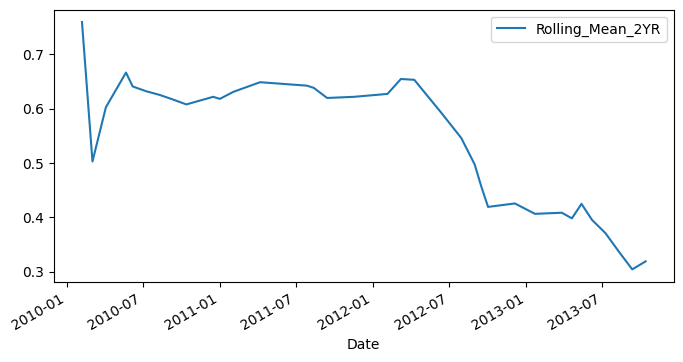

In [ ]:
dd = df_nbr[df_nbr['uid']==21718555].dropna(subset=['Rolling_Mean_2YR'])[['Timestamp','Rolling_Mean_2YR']].copy()
dd.plot(figsize=(8, 4))

<Axes: xlabel='Date'>

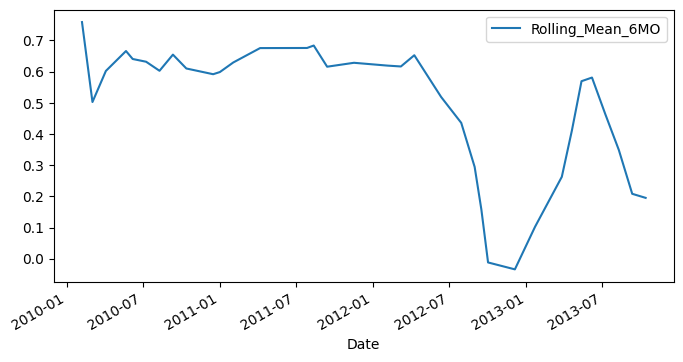

In [ ]:
dd = df_nbr2[df_nbr['uid']==21718555].dropna(subset=['Rolling_Mean_6MO'])[['Timestamp','Rolling_Mean_6MO']].copy()
dd.plot(figsize=(8, 4))

In [ ]:
annual_average_2years = df_nbr.groupby(['YrFireName','Dataset','uid']).resample('Y')['Rolling_Mean_2YR'].mean().reset_index()
tmp = pd.DataFrame(annual_average_2years)
tmp = tmp.rename(columns={"Rolling_Mean_2YR": "Annual_Average_2Years"})
tmp = tmp.sort_values(by=['YrFireName','Dataset','uid','Date'])
tmp['tmpkey'] = tmp['YrFireName'] + str(':') + tmp['Dataset'] + str(':') + tmp['uid'].astype(str)
tmp ##8727 rows × 6 columns

In [ ]:
annual_average_6months = df_nbr2.groupby(['YrFireName','Dataset','uid']).resample('6M')['Rolling_Mean_6MO'].mean().reset_index()
tmp = pd.DataFrame(annual_average_6months)
tmp = tmp.rename(columns={"Rolling_Mean_6MO": "Average_6Months"})
tmp = tmp.sort_values(by=['YrFireName','Dataset','uid','Date'])
tmp['tmpkey'] = tmp['YrFireName'] + str(':') + tmp['Dataset'] + str(':') + tmp['uid'].astype(str)
tmp ##8727 rows × 6 columns

,YrFireName,Dataset,uid,Date,Average_6Months,tmpkey
0,1982 - SEKI 69 or 74 Reburn,NPS,49232628,1984-05-31,0.495585,1982 - SEKI 69 or 74 Reburn:NPS:49232628
1,1982 - SEKI 69 or 74 Reburn,NPS,49232628,1984-11-30,0.467649,1982 - SEKI 69 or 74 Reburn:NPS:49232628
2,1982 - SEKI 69 or 74 Reburn,NPS,49370067,1984-05-31,0.644368,1982 - SEKI 69 or 74 Reburn:NPS:49370067
3,1982 - SEKI 69 or 74 Reburn,NPS,49370067,1984-11-30,0.685966,1982 - SEKI 69 or 74 Reburn:NPS:49370067
4,1982 - SEKI 69 or 74 Reburn,NPS,49370067,1985-05-31,0.717563,1982 - SEKI 69 or 74 Reburn:NPS:49370067
...,...,...,...,...,...,...
19625,2016 - Paradise 90,FERA,60711538,2017-01-31,0.573751,2016 - Paradise 90:FERA:60711538
19626,2016 - Paradise 90,FERA,60711538,2017-07-31,0.593941,2016 - Paradise 90:FERA:60711538
19627,2016 - Paradise 90,FERA,60711538,2018-01-31,0.610632,2016 - Paradise 90:FERA:60711538
19628,2016 - Paradise 90,FERA,60711538,2018-07-31,0.685367,2016 - Paradise 90:FERA:60711538


In [ ]:
tmp[tmp['uid']==79680243]

,YrFireName,Dataset,uid,Date,Average_6Months,tmpkey
10484,2003 - Griff,Progar,79680243,2002-06-30,0.424634,2003 - Griff:Progar:79680243
10485,2003 - Griff,Progar,79680243,2002-12-31,0.446215,2003 - Griff:Progar:79680243
10486,2003 - Griff,Progar,79680243,2003-06-30,0.000000,2003 - Griff:Progar:79680243
10487,2003 - Griff,Progar,79680243,2003-12-31,0.381626,2003 - Griff:Progar:79680243
10488,2003 - Griff,Progar,79680243,2004-06-30,0.436498,2003 - Griff:Progar:79680243
10489,2003 - Griff,Progar,79680243,2004-12-31,0.439074,2003 - Griff:Progar:79680243
10490,2003 - Griff,Progar,79680243,2005-06-30,0.362992,2003 - Griff:Progar:79680243
10491,2003 - Griff,Progar,79680243,2005-12-31,0.388508,2003 - Griff:Progar:79680243


In [ ]:
tmp['Average_6Months'] = tmp['Average_6Months'].fillna(0.0)

In [ ]:
#create unique list of names
UniqueNames = tmp.tmpkey.unique()

#create a data frame dictionary to store your data frames
DataFrameDict = {elem : pd.DataFrame() for elem in UniqueNames}

for key in DataFrameDict.keys():
    DataFrameDict[key] = tmp[:][tmp.tmpkey == key]
DataFrameDict

In [ ]:
list(DataFrameDict.values())[0]

,YrFireName,Dataset,uid,Date,Average_6Months,tmpkey
0,1982 - SEKI 69 or 74 Reburn,NPS,49232628,1984-12-31,0.473236,1982 - SEKI 69 or 74 Reburn:NPS:49232628


In [ ]:
# Find DataFrames with less than 4 rows
less_than_4_rows = {key: value for key, value in DataFrameDict.items() if len(value) < 4}

print("DataFrames with less than 4 rows:")
for key, df in less_than_4_rows.items():
    print(f"{key}: {len(df)} rows")
    print(df)

In [ ]:
# Find DataFrames with less than 8 rows
less_than_8_rows = {key: value for key, value in DataFrameDict.items() if len(value) < 8}

print("DataFrames with less than 8 rows:")
for key, df in less_than_8_rows.items():
    print(f"{key}: {len(df)} rows")
    print(df)

In [ ]:
less_than_4_rows_keys = [key for key, value in DataFrameDict.items() if len(value) < 4]

for key in less_than_4_rows_keys:
    DataFrameDict.pop(key)

In [ ]:
less_than_8_rows_keys = [key for key, value in DataFrameDict.items() if len(value) < 8]

for key in less_than_8_rows_keys:
    DataFrameDict.pop(key)

In [ ]:
list(DataFrameDict.values())[0]

In [ ]:
df_nbr_bkup = df_nbr.copy()
tmp_nbr_annual_avg_lst=[]
i=0
for key in DataFrameDict.keys():
  print('key: ', key)
  tmpDFD=DataFrameDict[key]

  pivot = pd.pivot_table(tmpDFD, values='Annual_Average_2Years',
                                index=['YrFireName', 'Dataset','uid'],
                                columns=['Date'])

  namesList = ['PrevYr_NBR','Yr0_NBR','Yr1_NBR','Yr2_NBR']
  pivot.columns = pivot.columns[:0].tolist() + namesList
  pivot.reset_index(inplace=True)
  tmp_FTMFINAL_pivot = pd.merge(df_nbr,pivot,on=['YrFireName','Dataset','uid'], how='inner').copy()
  tmp_nbr_annual_avg_lst.append(tmp_FTMFINAL_pivot)

df_FTM_nbr_annual_avg=pd.concat(tmp_nbr_annual_avg_lst)

In [ ]:
df_nbr_bkup = df_nbr2.copy()
tmp_nbr_6month_avg_lst=[]
i=0
for key in DataFrameDict.keys():
  print('key: ', key)
  tmpDFD=DataFrameDict[key]
  if len(tmpDFD) == 9:
    tmpDFD.drop(tmpDFD.tail(1).index,inplace=True)

  pivot = pd.pivot_table(tmpDFD, values='Average_6Months',
                                index=['YrFireName', 'Dataset','uid'],
                                columns=['Date'])

  namesList = ['PrevYr_H1_NBR','PrevYr_H2_NBR','Yr0_H1_NBR','Yr0_H2_NBR','Yr1_H1_NBR','Yr1_H2_NBR','Yr2_H1_NBR','Yr2_H2_NBR']
  #print(pivot)
  #print('------------------------------')
  pivot.columns = pivot.columns[:0].tolist() + namesList
  pivot.reset_index(inplace=True)
  tmp_FTMFINAL_pivot = pd.merge(df_nbr2,pivot,on=['YrFireName','Dataset','uid'], how='inner').copy()
  tmp_nbr_6month_avg_lst.append(tmp_FTMFINAL_pivot)

df_FTM_nbr_6month_avg=pd.concat(tmp_nbr_6month_avg_lst)

In [ ]:
'''
annual_average_2years = nbr_combined_df.groupby(['YrFireName','Dataset']).resample('Y')['Rolling_Mean_2YR'].mean().reset_index()
tmp = pd.DataFrame(annual_average_2years)
tmp = tmp.rename(columns={"Rolling_Mean_2YR": "Annual_Average_2Years"})
tmp = tmp.sort_values(by=['YrFireName','Dataset','Date'])
tmp['tmpkey'] = tmp['YrFireName'] + str(':') + tmp['Dataset']
tmp

#create unique list of names
UniqueNames = tmp.tmpkey.unique()

#create a data frame dictionary to store your data frames
DataFrameDict = {elem : pd.DataFrame() for elem in UniqueNames}

for key in DataFrameDict.keys():
    DataFrameDict[key] = tmp[:][tmp.tmpkey == key]
#DataFrameDict

tmp_nbr_annual_avg_lst=[]
for key in DataFrameDict.keys():
  tmpDFD=DataFrameDict[key]

  pivot = pd.pivot_table(tmpDFD, values='Annual_Average_2Years',
                                index=['YrFireName', 'Dataset'],
                                columns=['Date'])

  namesList = ['PrevYr_NBR','Yr0_NBR','Yr1_NBR','Yr2_NBR']
  pivot.columns = pivot.columns[:0].tolist() + namesList
  pivot.reset_index(inplace=True)
  tmp_FTMFINAL_pivot = pd.merge(df_FTM_pdsi_annual_avg,pivot,on=['YrFireName','Dataset'], how='inner').copy()
  tmp_nbr_annual_avg_lst.append(tmp_FTMFINAL_pivot)

df_FTM_pdsi_nbr_annual_avg=pd.concat(tmp_nbr_annual_avg_lst)
'''

In [ ]:
df_FTM_nbr_annual_avg.head()

,NBR,millis,system:index,Timestamp,Year,Month,YrFireName,Dataset,uid,yr_fire,Date,Rolling_Mean_2YR,PrevYr_NBR,Yr0_NBR,Yr1_NBR,Yr2_NBR
0,0.072115,539543308925,2_LT05_035028_19870205,1987-02-05 17:08:28.925,1987,2,1988 - Air Patrol,Hood,47018564,1988,1987-02-05,0.072115,0.134291,0.030722,-0.006577,0.032197
1,0.603168,543690618533,2_LT05_035028_19870325,1987-03-25 17:10:18.533,1987,3,1988 - Air Patrol,Hood,47018564,1988,1987-03-25,0.337641,0.134291,0.030722,-0.006577,0.032197
2,-0.076269,545073051572,2_LT05_035028_19870410,1987-04-10 17:10:51.572,1987,4,1988 - Air Patrol,Hood,47018564,1988,1987-04-10,0.199671,0.134291,0.030722,-0.006577,0.032197
3,0.019001,547837908843,2_LT05_035028_19870512,1987-05-12 17:11:48.843,1987,5,1988 - Air Patrol,Hood,47018564,1988,1987-05-12,0.154504,0.134291,0.030722,-0.006577,0.032197
4,0.014735,550602755883,2_LT05_035028_19870613,1987-06-13 17:12:35.883,1987,6,1988 - Air Patrol,Hood,47018564,1988,1987-06-13,0.126550,0.134291,0.030722,-0.006577,0.032197


In [ ]:
df_FTM_nbr_annual_avg.columns

Index(['NBR', 'millis', 'system:index', 'Timestamp', 'Year', 'Month',
       'YrFireName', 'Dataset', 'uid', 'yr_fire', 'Date', 'Rolling_Mean_2YR',
       'PrevYr_NBR', 'Yr0_NBR', 'Yr1_NBR', 'Yr2_NBR'],
      dtype='object')

In [ ]:
## Calculcate dNBR and RdNBR
## https://fireecology.springeropen.com/articles/10.1186/s42408-023-00223-1#:~:text=NBR%20decline%20was%20significantly%20correlated,threshold%20of%20105%20NBR%20decline
import numpy as np
df_FTM_nbr_annual_avg['dNBR'] = df_FTM_nbr_annual_avg['PrevYr_NBR'] - df_FTM_nbr_annual_avg['Yr1_NBR'] / np.sqrt(np.abs(df_FTM_nbr_annual_avg['PrevYr_NBR'] / 1000)).copy()
df_FTM_nbr_annual_avg['NBR_min'] = df_FTM_nbr_annual_avg[['Yr0_NBR','Yr1_NBR','Yr2_NBR']].min(axis=1).copy()
df_FTM_nbr_annual_avg['RdNBR'] = df_FTM_nbr_annual_avg['PrevYr_NBR'] - df_FTM_nbr_annual_avg['NBR_min'] / np.sqrt(np.abs(df_FTM_nbr_annual_avg['PrevYr_NBR'] / 1000)).copy()

In [ ]:
file_path = '/content/drive/My Drive/df_FTM_pdsi_nbr_annual_avg_2.csv'
df_FTM_nbr_annual_avg.to_csv(file_path, index=False)

In [ ]:
import numpy as np
df_FTM_nbr_6month_avg['dNBR_6MO'] = df_FTM_nbr_6month_avg['PrevYr_H2_NBR'] - df_FTM_nbr_6month_avg['Yr1_H1_NBR'] / np.sqrt(np.abs(df_FTM_nbr_6month_avg['PrevYr_H2_NBR'] / 1000)).copy()
df_FTM_nbr_6month_avg['NBR_min_6MO'] = df_FTM_nbr_6month_avg[['Yr0_H1_NBR','Yr0_H2_NBR','Yr1_H1_NBR','Yr1_H2_NBR','Yr2_H1_NBR','Yr2_H2_NBR']].min(axis=1).copy()
df_FTM_nbr_6month_avg['RdNBR_6MO'] = df_FTM_nbr_6month_avg['PrevYr_H2_NBR'] - df_FTM_nbr_6month_avg['NBR_min_6MO'] / np.sqrt(np.abs(df_FTM_nbr_6month_avg['PrevYr_H2_NBR'] / 1000)).copy()

In [ ]:
df_FTM_nbr_6month_avg.sample(5)

,NBR,millis,system:index,Timestamp,Year,Month,YrFireName,Dataset,uid,yr_fire,...,PrevYr_H2_NBR,Yr0_H1_NBR,Yr0_H2_NBR,Yr1_H1_NBR,Yr1_H2_NBR,Yr2_H1_NBR,Yr2_H2_NBR,dNBR_6MO,NBR_min_6MO,RdNBR_6MO
8,0.697055,1100110950700,2_LT05_043028_20041110,2004-11-10 18:22:30.700,2004,11,2005 - School,Progar,27037336,2005,...,0.676823,0.640671,0.600182,0.280692,0.200702,0.088274,0.329918,-10.112457,0.088274,-2.716255
10,0.527806,1005416805990,1_2_LE07_043030_20011110,2001-11-10 18:26:45.990,2001,11,2002 - Snow Mountain - Fall,Westlind,69618537,2002,...,0.662479,0.318548,0.534245,0.331565,0.543799,0.335017,0.530959,-12.219483,0.318548,-11.713743
18,0.425993,908473322208,2_LT05_037035_19981015,1998-10-15 17:42:02.208,1998,10,1998 - GRCA Outlet,NPS,19946648,1998,...,0.675106,0.476504,0.562664,0.468997,0.487730,0.436309,0.537449,-17.375183,0.436309,-16.117100
33,0.490047,1496860606050,1_1_LC08_043027_20170607,2017-06-07 18:36:46.050,2017,6,2015 - Grizzly,Hood_Idaho,78748014,2015,...,0.743203,0.635162,0.595145,0.568700,0.587021,0.319372,0.523895,-20.117527,0.319372,-10.971824
2,0.899236,984508857967,1_2_LE07_045030_20010313,2001-03-13 18:40:57.967,2001,3,2002 - Crater-FB-B,Perrakis,79390627,2002,...,0.707326,0.400049,0.582260,0.533471,0.691152,0.435957,0.699618,-19.351295,0.400049,-14.334609


In [ ]:
file_path = '/content/drive/My Drive/df_FTM_nbr_6month_avg.csv'
df_FTM_nbr_6month_avg.to_csv(file_path, index=False)

In [ ]:
df_FTM_nbr_annual_avg.columns

Index(['NBR', 'millis', 'system:index', 'Timestamp', 'Year', 'Month',
       'YrFireName', 'Dataset', 'uid', 'yr_fire', 'Date', 'Rolling_Mean_2YR',
       'PrevYr_NBR', 'Yr0_NBR', 'Yr1_NBR', 'Yr2_NBR', 'dNBR', 'NBR_min',
       'RdNBR'],
      dtype='object')

In [ ]:
NBR_TMP = df_FTM_nbr_annual_avg[['YrFireName','Dataset','uid','yr_fire','PrevYr_NBR','Yr0_NBR','Yr1_NBR','Yr2_NBR','dNBR','NBR_min','RdNBR']].copy()
NBR_TMP = NBR_TMP.drop_duplicates()
del df_FTM_nbr_annual_avg

NBR_TMP_2 = df_FTM_nbr_6month_avg[['YrFireName','Dataset','uid','PrevYr_H1_NBR', 'PrevYr_H2_NBR', 'Yr0_H1_NBR', 'Yr0_H2_NBR','Yr1_H1_NBR', 'Yr1_H2_NBR', 'Yr2_H1_NBR', 'Yr2_H2_NBR', 'dNBR_6MO',
                                   'NBR_min_6MO', 'RdNBR_6MO']].copy()
NBR_TMP_2 = NBR_TMP_2.drop_duplicates()
del df_FTM_nbr_6month_avg

df_FTM_nbr_all = NBR_TMP.merge(NBR_TMP_2, on=['YrFireName','Dataset','uid'])
file_path = '/content/drive/My Drive/df_FTM_nbr_all.csv'
df_FTM_nbr_all.to_csv(file_path, index=False)

In [ ]:
df_FTM_nbr_annual_avg[df_FTM_nbr_annual_avg['uid']==39915458]

# Combine PDSI and NBR data into single dataframe

In [ ]:
## load PDSI
#file_path = '/content/drive/My Drive/df_FTM_pdsi_nbr_annual_avg.csv'
file_path = '/content/drive/My Drive/df_FTM_pdsi_all.csv'
df_FTM_pdsi_all = pd.read_csv(file_path)
df_FTM_pdsi_all.head(5)

,YrFireName,Dataset,uid,yr_fire,Longitude,Latitude,PrevYr_PDSI,Yr0_PDSI,Yr1_PDSI,Yr2_PDSI,PrevYr_H1,PrevYr_H2,Yr0_H1,Yr0_H2,Yr1_H1,Yr1_H2,Yr2_H1,Yr2_H2
0,1981 - Manning Basin,Brown,47149889,1981,-111.048065,42.471499,1.180234,0.458055,-0.046168,2.238681,0.667431,2.139102,-0.100653,-2.714655,-0.316536,3.359708,4.265538,4.997919
1,1981 - Manning Basin,Brown,47368165,1981,-111.053830,42.473682,1.180234,0.458055,-0.046168,2.238681,0.667431,2.139102,-0.100653,-2.714655,-0.316536,3.359708,4.265538,4.997919
2,1981 - Manning Basin,Brown,48201734,1981,-111.055792,42.482017,0.998056,0.077613,-0.285857,2.088259,0.630768,1.671135,-0.636127,-2.911414,-0.252647,3.229230,3.983146,4.726618
3,1981 - Manning Basin,Brown,48621235,1981,-111.065309,42.486212,0.998056,0.077613,-0.285857,2.088259,0.630768,1.671135,-0.636127,-2.911414,-0.252647,3.229230,3.983146,4.726618
4,1981 - Manning Basin,Brown,49138332,1981,-111.074620,42.491383,0.933905,0.011721,-0.282480,2.117834,0.587984,1.573487,-0.742034,-2.820866,-0.163785,3.204255,4.007635,4.709539


In [ ]:
## load NBR
#file_path = '/content/drive/My Drive/df_FTM_pdsi_nbr_annual_avg_2.csv'
file_path = '/content/drive/My Drive/df_FTM_nbr_all.csv'
df_FTM_nbr_all = pd.read_csv(file_path)
df_FTM_nbr_all.head(5)

,YrFireName,Dataset,uid,yr_fire,PrevYr_NBR,Yr0_NBR,Yr1_NBR,Yr2_NBR,dNBR,NBR_min,...,PrevYr_H2_NBR,Yr0_H1_NBR,Yr0_H2_NBR,Yr1_H1_NBR,Yr1_H2_NBR,Yr2_H1_NBR,Yr2_H2_NBR,dNBR_6MO,NBR_min_6MO,RdNBR_6MO
0,1988 - Air Patrol,Hood,47018564,1988,0.134291,0.030722,-0.006577,0.032197,0.701849,-0.006577,...,0.169376,-0.019597,-0.033450,-0.024632,0.017268,-0.045801,0.092695,2.062042,-0.045801,3.688584
1,1988 - Air Patrol,Hood,48562579,1988,0.584825,0.508283,0.380343,0.254078,-15.142777,0.254078,...,0.583027,0.505122,0.489844,0.375206,0.302511,0.120081,0.221245,-14.956054,0.120081,-4.390099
2,1988 - Air Patrol,Hood,48714163,1988,0.567420,0.496715,0.343179,0.183233,-13.839410,0.183233,...,0.584350,0.504032,0.486283,0.346128,0.280943,0.081098,0.119453,-13.734259,0.081098,-2.770520
3,1988 - Air Patrol,Hood,49965744,1988,0.465718,0.305865,0.202177,0.124174,-8.902769,0.124174,...,0.473172,0.249728,0.239253,0.172830,0.196736,-0.014433,0.102922,-7.472126,-0.014433,1.136665
4,1988 - Air Patrol,Hood,50649477,1988,0.279388,0.141038,0.081578,0.109233,-4.601134,0.081578,...,0.311066,0.117440,0.072055,-0.031896,0.111335,0.042322,0.159136,2.119540,-0.031896,2.119540


In [ ]:
df_FTM_nbr_all.columns

Index(['YrFireName', 'Dataset', 'uid', 'yr_fire', 'PrevYr_NBR', 'Yr0_NBR',
       'Yr1_NBR', 'Yr2_NBR', 'dNBR', 'NBR_min', 'RdNBR', 'PrevYr_H1_NBR',
       'PrevYr_H2_NBR', 'Yr0_H1_NBR', 'Yr0_H2_NBR', 'Yr1_H1_NBR', 'Yr1_H2_NBR',
       'Yr2_H1_NBR', 'Yr2_H2_NBR', 'dNBR_6MO', 'NBR_min_6MO', 'RdNBR_6MO'],
      dtype='object')

In [ ]:
PDSI_TMP = df_FTM_pdsi_all[['YrFireName','Dataset','uid','yr_fire','Longitude','Latitude','PrevYr_PDSI','Yr0_PDSI','Yr1_PDSI','Yr2_PDSI','PrevYr_H1',
                            'PrevYr_H2','Yr0_H1','Yr0_H2','Yr1_H1','Yr1_H2','Yr2_H1','Yr2_H2']].copy()
del df_FTM_pdsi_all

In [ ]:
PDSI_TMP = PDSI_TMP.drop_duplicates()

In [ ]:
NBR_TMP = df_FTM_nbr_all[['YrFireName','Dataset','uid','PrevYr_NBR','Yr0_NBR','Yr1_NBR','Yr2_NBR','dNBR','NBR_min','RdNBR','PrevYr_H1_NBR',
                          'PrevYr_H2_NBR','Yr0_H1_NBR','Yr0_H2_NBR','Yr1_H1_NBR','Yr1_H2_NBR','Yr2_H1_NBR','Yr2_H2_NBR','dNBR_6MO','NBR_min_6MO','RdNBR_6MO']].copy()
del df_FTM_nbr_all

In [ ]:
NBR_TMP = NBR_TMP.drop_duplicates()

In [ ]:
df_FTM_FINAL = PDSI_TMP.merge(NBR_TMP, on=['YrFireName','Dataset','uid'])

In [ ]:
df_FTM_FINAL.head()

,YrFireName,Dataset,uid,yr_fire,Longitude,Latitude,PrevYr_PDSI,Yr0_PDSI,Yr1_PDSI,Yr2_PDSI,...,PrevYr_H2_NBR,Yr0_H1_NBR,Yr0_H2_NBR,Yr1_H1_NBR,Yr1_H2_NBR,Yr2_H1_NBR,Yr2_H2_NBR,dNBR_6MO,NBR_min_6MO,RdNBR_6MO
0,1988 - Air Patrol,Hood,47018564,1988,-106.563537,45.470186,-0.097345,-0.890418,-2.063191,-1.757568,...,0.169376,-0.019597,-0.033450,-0.024632,0.017268,-0.045801,0.092695,2.062042,-0.045801,3.688584
1,1988 - Air Patrol,Hood,48562579,1988,-106.582144,45.485626,-0.097345,-0.890418,-2.063191,-1.757568,...,0.583027,0.505122,0.489844,0.375206,0.302511,0.120081,0.221245,-14.956054,0.120081,-4.390099
2,1988 - Air Patrol,Hood,48714163,1988,-106.587045,45.487142,-0.097345,-0.890418,-2.063191,-1.757568,...,0.584350,0.504032,0.486283,0.346128,0.280943,0.081098,0.119453,-13.734259,0.081098,-2.770520
3,1988 - Air Patrol,Hood,49965744,1988,-106.573856,45.499657,-0.097345,-0.890418,-2.063191,-1.757568,...,0.473172,0.249728,0.239253,0.172830,0.196736,-0.014433,0.102922,-7.472126,-0.014433,1.136665
4,1988 - Air Patrol,Hood,50649477,1988,-106.600933,45.506495,-0.208127,-0.849440,-1.987150,-1.734241,...,0.311066,0.117440,0.072055,-0.031896,0.111335,0.042322,0.159136,2.119540,-0.031896,2.119540


In [ ]:
# File path in your Google Drive
file_path = '/content/drive/My Drive/FTM_trees.csv'

# Load FTM_fires.csv into Pandas DataFrame
df_FTM_trees = pd.read_csv(file_path,low_memory=False)
df_FTM_trees.head(1)

,YrFireName,Species,Dataset,Times_burned,ID,Plot,TreeNum,Unit,Genus,Species_name,...,IPS,MPB,RPB,RTB,SB,WPB,WB,SPB,CVS_percent_source,CVK_percent_source
0,2006 - Tripod,2TREE,Prichard,1,NaN,188,15,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,F,NaN


In [ ]:
file_path = '/content/drive/My Drive/df_FTM_FINAL.csv'
df_FTM_FINAL = pd.read_csv(file_path)
df_FTM_FINAL.sample(5)

,YrFireName,Dataset,uid,yr_fire,Longitude,Latitude,PrevYr_PDSI,Yr0_PDSI,Yr1_PDSI,Yr2_PDSI,PrevYr_NBR,Yr0_NBR,Yr1_NBR,Yr2_NBR,dNBR,NBR_min,RdNBR,tree_status
1771,2007 - Monument,Westlind,99800824,2007,-119.452304,44.998008,-0.171690,-0.757999,-1.861880,-2.729482,0.530446,0.477018,0.457757,0.464854,-19.344891,0.457757,-19.344891,1.0
387,1997 - Kidd Flat - Fall,Westlind,81788121,1997,-118.983674,43.817881,2.254240,2.900441,3.098443,3.390397,0.577456,0.449839,0.437256,0.438790,-17.618557,0.437256,-17.618557,1.0
1785,2007 - Owen,Westlind,28169808,2007,-120.937214,42.281698,2.860754,0.791342,-1.136734,-2.229163,0.419055,0.171305,0.179703,0.234468,-8.359455,0.171305,-7.949185,1.0
705,2001 - GRCA Walla Valley,NPS,33242742,2001,-112.215795,36.332427,-2.037444,-1.939312,-2.263207,-3.220372,0.623820,0.611897,0.604203,0.586240,-23.567157,0.586240,-22.847949,1.0
1789,2007 - Owen,Westlind,32386322,2007,-120.849226,42.323863,2.708061,0.516389,-1.414699,-2.408011,0.614999,0.572463,0.562052,0.547346,-22.049160,0.547346,-21.456155,1.0


In [ ]:
#df_FTM_FINAL = df_FTM_FINAL.drop(columns=['tree_status'])
#df_FTM_FINAL.head(1)

,YrFireName,Dataset,uid,yr_fire,Longitude,Latitude,PrevYr_PDSI,Yr0_PDSI,Yr1_PDSI,Yr2_PDSI,PrevYr_NBR,Yr0_NBR,Yr1_NBR,Yr2_NBR,dNBR,NBR_min,RdNBR
0,1988 - Air Patrol,Hood,47018564,1988,-106.563537,45.470186,-0.097345,-0.890418,-2.063191,-1.757568,0.134291,0.030722,-0.006577,0.032197,0.701849,-0.006577,0.701849


In [ ]:
'''
alive_tree_filter = df_FTM_trees.groupby(['YrFireName','Dataset']).agg({'yr0status': lambda x: x.sum(skipna=True),
                                     'yr1status': lambda x: x.sum(skipna=True)})
df_FTM_trees_alive = alive_tree_filter[(alive_tree_filter.T == 0).all()].copy()
df_FTM_trees_alive['tree_status'] = 0
df_FTM_trees_alive.reset_index(inplace=True)
df_FTM_trees_alive = df_FTM_trees_alive.drop(['yr0status','yr1status'], axis=1)
df_FTM_trees_alive
'''
dead_tree_filter_1 = df_FTM_trees.groupby(['YrFireName','Dataset']).agg({'yr0status': lambda x: x.sum(skipna=True),
                                     'yr1status': lambda x: x.sum(skipna=True)})
df_FTM_trees_dead = dead_tree_filter_1[(dead_tree_filter_1.T != 0).any()].copy()
df_FTM_trees_dead['tree_status'] = 1
df_FTM_trees_dead.reset_index(inplace=True)
df_FTM_trees_dead = df_FTM_trees_dead.drop(['yr0status','yr1status'], axis=1)
df_FTM_trees_dead

In [ ]:
df_FTM_FINAL = pd.merge(df_FTM_FINAL,df_FTM_trees_dead,left_on=['YrFireName','Dataset'],right_on=['YrFireName','Dataset'],how='left')
df_FTM_FINAL['tree_status'] = df_FTM_FINAL['tree_status'].fillna(2)
df_FTM_FINAL

<Axes: >

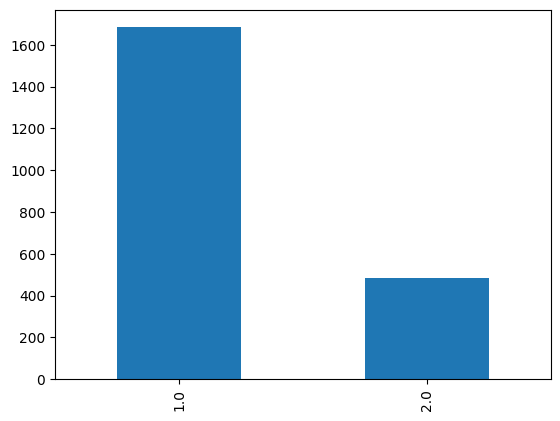

In [ ]:
df_FTM_FINAL['tree_status'].value_counts().plot(kind='bar')

In [ ]:
df_FTM_FINAL[df_FTM_FINAL['tree_status']==0]

In [ ]:
df_FTM_trees[df_FTM_trees['YrFireName']=='2016 - Paradise 90'][['YrFireName','Dataset','Species','yr0status','yr1status','yr2status','yr3status','yr4status','yr5status','yr6status','yr7status','yr8status','yr9status','yr10status']]

In [ ]:
file_path = '/content/drive/My Drive/df_FTM_FINAL.csv'
df_FTM_FINAL.to_csv(file_path, index=False)

# Get more data for alive trees to balance the count of dead and alive trees in final dataset to be used for model

In [ ]:
df_FTM_fires.head()

,YrFireName,Fire,Dataset,yr_fire,Latitude,Longitude,Elevation,month_fire,day_fire,State
0,1981 - Manning Basin,Manning Basin,Brown,1981,42.602739,-111.119003,2028,9.0,22.0,Idaho
1,1981 - Snowdrift,Snowdrift,Brown,1981,42.549037,-111.226913,2860,9.0,22.0,Idaho
2,1981 - Steep Creek,Steep Creek,Brown,1981,42.272226,-110.556666,2368,9.0,28.0,Wyoming
3,1982 - SEKI 69 or 74 Reburn,SEKI 69 or 74 Reburn,NPS,1982,36.706663,-118.920540,1903,NaN,NaN,California
4,1983 - Oops,Oops,Hood,1983,48.359752,-116.752536,1303,10.0,NaN,Idaho


In [ ]:
file_path = '/content/drive/My Drive/df_FTM_FINAL.csv'
df_FTM_FINAL = pd.read_csv(file_path)
df_FTM_FINAL.sample(5)

,YrFireName,Dataset,uid,yr_fire,Longitude,Latitude,PrevYr_PDSI,Yr0_PDSI,Yr1_PDSI,Yr2_PDSI,PrevYr_NBR,Yr0_NBR,Yr1_NBR,Yr2_NBR,dNBR,NBR_min,RdNBR,tree_status
1727,2007 - GRCA Tusayan,NPS,784011,2007,-112.046985,36.007840,-2.893224,-2.336295,-1.235307,-0.154311,0.374586,0.342095,0.335164,0.314504,-16.942760,0.314504,-15.875328,0.0
126,1992 - GRCA Northwest1,NPS,38105742,1992,-112.348234,36.381057,-0.847542,-0.203018,1.618984,2.390277,0.538238,0.502168,0.513352,0.539135,-21.589037,0.502168,-21.106950,1.0
1710,2007 - GRCA Grandview,NPS,99958864,2007,-112.102558,35.999589,-3.073797,-2.733261,-1.919663,-1.008070,0.014332,0.054834,0.091567,0.080562,-24.172433,0.054834,-14.469718,1.0
890,2002 - Gulf Coastal Plain Solon Dixon AL 103,McIver,12118234,2002,-86.700591,31.121182,-3.131462,-2.247242,-0.877135,0.981328,0.496521,0.478478,0.457526,0.448667,-20.036230,0.448667,-19.638647,1.0
1781,2007 - Neola North,Lerch,60714270,2007,-110.049369,40.607143,0.191167,-0.547654,-1.335071,-1.959235,0.566880,0.447829,0.355317,0.312484,-14.356586,0.312484,-12.557589,1.0


In [ ]:
df_States = pd.merge(df_FTM_FINAL,df_FTM_fires,left_on=['YrFireName','Dataset'],right_on=['YrFireName','Dataset'],how='left')
df_States = df_States[['State', 'yr_fire_x', 'Elevation']].copy()
df_States.rename({'yr_fire_x': 'yr_fire'}, axis=1, inplace=True)
df_States.drop_duplicates(inplace=True)
df_States.sample(5)

,State,yr_fire,Elevation
1852,Arizona,2008,2520
0,Montana,1988,1269
804,Wyoming,2001,2424
1916,Arizona,2009,2108
117,Arizona,1992,2437


<Axes: >

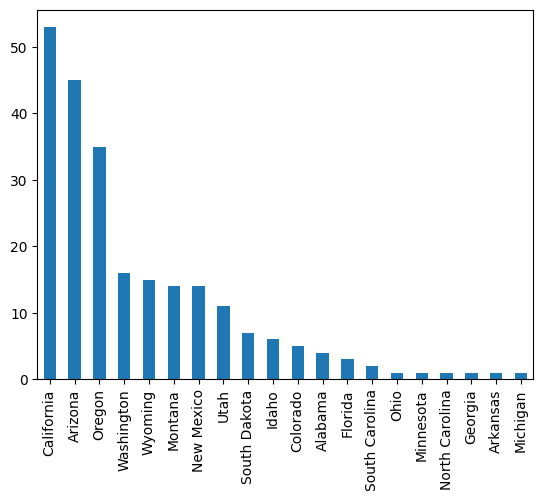

In [ ]:
df_States['State'].value_counts().plot(kind='bar')

In [ ]:
# Manually collect list of random coordinates from 20 states where there was never a fire.
# Use https://apps.fs.usda.gov/lcms-viewer/mtbs.html to explore the burned area maps and pick locations outside those

alive_tree_state_loc_lst = [['Montana', 46.728280153250616, -109.94435781566675]
,['Arizona', 34.74984434562247, -112.1759199190795]
,['Oregon', 45.80337176430846, -123.25846118926371]
,['New Mexico', 33.8064004812095, -108.87881270321165]
,['Washington', 48.771792880817856, -122.09444440263132]
,['Wyoming', 43.423007882283805, -110.12148523767932]
,['Florida', 28.121608461465236, -82.18507002149596]
,['Georgia', 32.73902640119615, -83.58962765688365]
,['Idaho', 44.40321588676348, -114.40839301759972]
,['Arkansas', 33.9316578112831, -92.26067365695366]
,['Colorado', 38.8861182901808, -106.85201923578192]
,['Ohio', 40.58892297765979, -82.30307541722917]
,['North Carolina', 35.268343581614886, -82.81346565062759]
,['Alabama', 32.80501426885022, -87.15584367831674]
,['Michigan', 44.01407041376535, -85.98592873166513]
,['Minnesota', 46.2600350419297, -95.41699706766332]
,['South Dakota', 44.22737362249917, -100.29207566709275]
,['California', 35.76641911734362, -118.7783545506189]
,['Montana', 46.97685671220315, -111.05332467993253]
,['Utah', 37.9110351697689, -111.90485055424162]]

In [ ]:
## Create a dataframe df_Loc_No_fires by getting 60 random points in vicinity of sample locations alive_tree_state_loc_lst
## Use the year same as the year when there is entry for fire in that state
df_Loc_No_fires = pd.DataFrame(alive_tree_state_loc_lst)
df_Loc_No_fires.columns = ['State','Latitude','Longitude']
df_Loc_No_fires.head(1)

,State,Latitude,Longitude
0,Montana,46.72828,-109.944358


In [ ]:
idx = df_FTM_fires.groupby('State')['yr_fire'].idxmax()
max_yr_fire = df_FTM_fires.loc[idx]
#max_yr_fire
df_Loc_No_fires = pd.merge(df_Loc_No_fires,max_yr_fire,left_on=['State'],right_on=['State'],how='left')[['State',	'Latitude_x',	'Longitude_x', 'yr_fire']].copy()
df_Loc_No_fires = df_Loc_No_fires.rename(columns={"Latitude_x": "Latitude","Longitude_x": "Longitude"})
df_Loc_No_fires

,State,Latitude,Longitude,yr_fire
0,Montana,46.728280,-109.944358,2011
1,Arizona,34.749844,-112.175920,2014
2,Oregon,45.803372,-123.258461,2012
3,New Mexico,33.806400,-108.878813,2008
4,Washington,48.771793,-122.094444,2016
5,Wyoming,43.423008,-110.121485,2016
6,Florida,28.121608,-82.185070,2002
7,Georgia,32.739026,-83.589628,2005
8,Idaho,44.403216,-114.408393,2015
9,Arkansas,33.931658,-92.260674,2011


In [ ]:
random_sample_lst = []
for index, row in df_Loc_No_fires.iterrows():
    print(row['Longitude'], row['Latitude'])
    # Create a point of interest using the provided latitude and longitude
    point_of_interest = ee.Geometry.Point(row['Longitude'], row['Latitude'])

    # Define a region around the point of interest (5000 meters radius in this example)
    region = point_of_interest.buffer(1000)  # You can adjust the buffer size as needed

    random_points = ee.FeatureCollection.randomPoints(region=region, points=59, seed=0, maxError=1)
    #print(random_points.geometry().coordinates().getInfo())
    pt_dict = random_points.geometry().coordinates().getInfo()
    df_sample = pd.DataFrame(pt_dict)
    df_sample.columns = ['Longitude', 'Latitude']
    df_sample['State'] = row['State']
    df_sample['yr_fire'] = row['yr_fire']
    random_sample_lst.append(df_sample)
pd.concat(random_sample_lst)

-109.94435781566675 46.728280153250616
-112.1759199190795 34.74984434562247
-123.25846118926371 45.80337176430846
-108.87881270321165 33.8064004812095
-122.09444440263132 48.771792880817856
-110.12148523767932 43.423007882283805
-82.18507002149596 28.121608461465236
-83.58962765688365 32.73902640119615
-114.40839301759972 44.40321588676348
-92.26067365695366 33.9316578112831
-106.85201923578192 38.8861182901808
-82.30307541722917 40.58892297765979
-82.81346565062759 35.268343581614886
-87.15584367831674 32.80501426885022
-85.98592873166513 44.01407041376535
-95.41699706766332 46.2600350419297
-100.29207566709275 44.22737362249917
-118.7783545506189 35.76641911734362
-111.05332467993253 46.97685671220315
-111.90485055424162 37.9110351697689


,Longitude,Latitude,State,yr_fire
0,-109.939611,46.732574,Montana,2011
1,-109.933186,46.723949,Montana,2011
2,-109.951997,46.734582,Montana,2011
3,-109.943809,46.735981,Montana,2011
4,-109.941966,46.724669,Montana,2011
...,...,...,...,...
54,-111.904089,37.907072,Utah,2008
55,-111.909006,37.911310,Utah,2008
56,-111.898656,37.916926,Utah,2008
57,-111.912717,37.908276,Utah,2008


In [ ]:
del df_sample

In [ ]:
df_sample = pd.concat(random_sample_lst)
df_sample = df_sample[['State','Latitude','Longitude','yr_fire']].copy()
df_Loc_No_fires = df_Loc_No_fires.append(df_sample)
df_Loc_No_fires.reset_index(inplace=True)
df_Loc_No_fires

<ipython-input-90-5c889ecedd02>:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_Loc_No_fires = df_Loc_No_fires.append(df_sample)


,index,State,Latitude,Longitude,yr_fire
0,0,Montana,46.728280,-109.944358,2011
1,1,Arizona,34.749844,-112.175920,2014
2,2,Oregon,45.803372,-123.258461,2012
3,3,New Mexico,33.806400,-108.878813,2008
4,4,Washington,48.771793,-122.094444,2016
...,...,...,...,...,...
1195,54,Utah,37.907072,-111.904089,2008
1196,55,Utah,37.911310,-111.909006,2008
1197,56,Utah,37.916926,-111.898656,2008
1198,57,Utah,37.908276,-111.912717,2008


In [ ]:
df_Loc_No_fires[df_Loc_No_fires['State'] == 'Colorado']

# Collect PDSI from google earthe engine datasets for sample alive trees

In [ ]:
def check_existence(latitude, longitude, coordinates):
    return (latitude, longitude) in coordinates

coordinates_list  = []
for index, row in df_Loc_No_fires.iterrows():
    print('index:', index, '::', row['State'], row['Longitude'], row['Latitude'])
    if check_existence(row['Latitude'], row['Longitude'], coordinates_list):
        print(row['Latitude'], ' ', row['Longitude'], ' exists in the list.')
    #elif index < 393:
    #    print('index:', index)
    #elif row['YrFireName'] == '2010 - Gilles Creek':
    #    print('skipping....')
    #    print(row['YrFireName'])
    else:
        yr = str(int(row['yr_fire']))
        sample_point = ee.Geometry.Point(row['Longitude'], row['Latitude'])
        pdsi = get_pdsi_collection(yr)
        pdsi_df = get_pdsi(pdsi,sample_point)
        pdsi_df['YrFireName'] = 'Alive_Tree_Record'
        pdsi_df['Dataset'] = ''
        pdsi_df['yr_fire'] = row['yr_fire']
        pdsi_df['Longitude'] = row['Longitude']
        pdsi_df['Latitude'] = row['Latitude']
        frnm = 'Alive_Tree_Record'
        st = str(row['State'])
        file_path = '/content/drive/My Drive/PDSI_FINAL/99_PDSI_' + str(index) + '_' + frnm + '_' + st + '.csv'
        pdsi_df.to_csv(file_path, index=False)
        coordinates_list.append((row['Latitude'],row['Longitude']))

# Load PDSI data of alive trees for processing

In [ ]:
import os
import regex as re

from google.colab import drive
drive.mount('/content/drive')

# Define the folder path in your Google Drive where your files are stored
folder_path = '/content/drive/My Drive/PDSI_FINAL'

# List files in the folder that start with a certain string
file_list = [file for file in os.listdir(folder_path) if file.startswith('99_PDSI_')]

# Read all files into a Pandas DataFrame
dfs = []
i=1
for file_name in file_list:
    print(i,'..',file_name)
    file_path = os.path.join(folder_path, file_name)
    # Assuming files are CSV, change the read function accordingly for other formats
    df = pd.read_csv(file_path)

    df['uid'] = ((df['Latitude'] * 100000000) % 100000000).astype(int)
    df['Date'] = pd.to_datetime(df['Timestamp'],format='%Y-%m-%d').dt.date
    df.index = pd.DatetimeIndex(df["Date"])
    df = df.sort_index()


    rolling_mean = df['PDSI'].rolling(window='730D',min_periods=1).mean()
    df['Rolling_Mean_2YR'] = rolling_mean

    annual_average_2years = df.groupby(['YrFireName','uid']).resample('Y')['Rolling_Mean_2YR'].mean().reset_index()
    tmp = pd.DataFrame(annual_average_2years)
    tmp = tmp.rename(columns={"Rolling_Mean_2YR": "Annual_Average_2Years"})
    tmp = tmp.sort_values(by=['YrFireName','uid','Date'])

    pivot = pd.pivot_table(tmp, values='Annual_Average_2Years',
                                index=['YrFireName', 'uid'],
                                columns=['Date'])

    namesList = ['PrevYr_PDSI','Yr0_PDSI','Yr1_PDSI','Yr2_PDSI']
    pivot.columns = pivot.columns[:0].tolist() + namesList
    pivot.reset_index(inplace=True)
    tmp_pivot1 = pd.merge(df,pivot,on=['YrFireName','uid'], how='inner').copy()
    #print(tmp_pivot1)

    rolling_mean_6MO = df['PDSI'].rolling(window='180D',min_periods=1).mean()
    df['Rolling_Mean_6MO'] = rolling_mean_6MO

    average_6months = df.groupby(['YrFireName','uid']).resample('180D')['Rolling_Mean_6MO'].mean().reset_index()
    tmp = pd.DataFrame(average_6months)
    tmp = tmp.rename(columns={"Rolling_Mean_6MO": "Average_6Months"})
    tmp = tmp.sort_values(by=['YrFireName','uid','Date'])

    pivot2 = pd.pivot_table(tmp, values='Average_6Months',
                                index=['YrFireName', 'uid'],
                                columns=['Date'])

    namesList = ['PrevYr_H1','PrevYr_H2','Yr0_H1','Yr0_H2','Yr1_H1','Yr1_H2','Yr2_H1','Yr2_H2','IGNORE']
    pivot2.columns = pivot2.columns[:0].tolist() + namesList
    pivot2.reset_index(inplace=True)
    tmp_pivot2 = pd.merge(df,pivot2,on=['YrFireName','uid'], how='inner').copy()
    #print(tmp_pivot2)

    tmp_pivot = pd.merge(tmp_pivot1,tmp_pivot2,on=['YrFireName','uid'], how='inner').copy()


    PDSI = tmp_pivot[['YrFireName','uid','PrevYr_PDSI','Yr0_PDSI','Yr1_PDSI','Yr2_PDSI','PrevYr_H1',
                            'PrevYr_H2','Yr0_H1','Yr0_H2','Yr1_H1','Yr1_H2','Yr2_H1','Yr2_H2']].copy()
    PDSI = PDSI.drop_duplicates()
    #print(PDSI)
    dfs.append(PDSI)
    i+=1
    #if i>20:
    #  break

# Concatenate all DataFrames
pdsi_combined_df = pd.concat(dfs, ignore_index=True)

# Display combined DataFrame
print(pdsi_combined_df.shape)

In [ ]:
pdsi_combined_df

In [ ]:
file_path = '/content/drive/My Drive/df_FTM_pdsi_annual_avg_additional_alive.csv'
pdsi_combined_df.to_csv(file_path, index=False)

# Collect NBR from google earthe engine datasets for sample alive trees

In [ ]:
def check_existence(latitude, longitude, coordinates):
    return (latitude, longitude) in coordinates

coordinates_list  = []

for index, row in df_Loc_No_fires.iterrows():
    print('index:', index, '::', row['State'], row['Longitude'], row['Latitude'])
    if check_existence(row['Latitude'], row['Longitude'], coordinates_list):
        print(row['Latitude'], ' ', row['Longitude'], ' exists in the list.')
    else:
       yr = str(int(row['yr_fire']))
       sample_point = ee.Geometry.Point(row['Longitude'], row['Latitude'])
       landsat_col = get_landsat_collection(yr,sample_point)
       landsat_col_size = landsat_col.size().getInfo()
       print('landsat_col_size:', landsat_col_size)
       if landsat_col_size == 0:
          #skipped_uid_list.append(row['uid'])
          #skiped_uid = row['uid']
          print('Error: No image available..')
       else:
          nbr_df = get_nbr(landsat_col,sample_point)
          nbr_df['YrFireName'] = 'Alive_Tree_Record'
          nbr_df['Dataset'] = ''
          nbr_df['yr_fire'] = row['yr_fire']
          nbr_df['Longitude'] = row['Longitude']
          nbr_df['Latitude'] = row['Latitude']
          frnm = 'Alive_Tree_Record'
          st = str(row['State'])
          file_path = '/content/drive/My Drive/NBR_FINAL/99_NBR_' + str(index) + '_' + frnm + '_' + st + '.csv'
          nbr_df.to_csv(file_path, index=False)
          coordinates_list.append((row['Latitude'],row['Longitude']))

# Load NBR data of alive trees for processing

In [ ]:
tmp.shape[0]

8

In [ ]:
import os
import regex as re
# Define the folder path in your Google Drive where your files are stored
folder_path = '/content/drive/My Drive/NBR_FINAL'

# List files in the folder that start with a certain string
file_list = [file for file in os.listdir(folder_path) if file.startswith('99_NBR_')]

# Read all files into a Pandas DataFrame
dfs = []
i=1
for file_name in file_list:
    print(i,'..',file_name)
    file_path = os.path.join(folder_path, file_name)
    # Assuming files are CSV, change the read function accordingly for other formats
    df = pd.read_csv(file_path)

    df['uid'] = ((df['Latitude'] * 100000000) % 100000000).astype(int)
    df['Date'] = pd.to_datetime(df['Timestamp'],format='%Y-%m-%d').dt.date
    df.index = pd.DatetimeIndex(df["Date"])
    df = df.sort_index()



    rolling_mean = df['NBR'].rolling(window='730D',min_periods=1).mean()
    df['Rolling_Mean_2YR'] = rolling_mean
    annual_average_2years = df.groupby(['YrFireName','uid']).resample('Y')['Rolling_Mean_2YR'].mean().reset_index()
    tmp = pd.DataFrame(annual_average_2years)
    tmp = tmp.rename(columns={"Rolling_Mean_2YR": "Annual_Average_2Years"})
    tmp = tmp.sort_values(by=['YrFireName','uid','Date'])

    pivot = pd.pivot_table(tmp, values='Annual_Average_2Years',
                                index=['YrFireName', 'uid'],
                                columns=['Date'])

    namesList = ['PrevYr_NBR','Yr0_NBR','Yr1_NBR','Yr2_NBR']
    pivot.columns = pivot.columns[:0].tolist() + namesList
    pivot.reset_index(inplace=True)
    tmp_pivot1 = pd.merge(df,pivot,on=['YrFireName','uid'], how='inner').copy()


    rolling_mean = df['NBR'].rolling(window='180D',min_periods=1).mean()
    df['Rolling_Mean_6MO'] = rolling_mean
    average_6months = df.groupby(['YrFireName','uid']).resample('180D')['Rolling_Mean_6MO'].mean().reset_index()
    tmp = pd.DataFrame(average_6months)
    tmp = tmp.rename(columns={"Rolling_Mean_6MO": "Average_6Months"})
    tmp = tmp.sort_values(by=['YrFireName','uid','Date'])
    if tmp.shape[0] == 9:
      tmp = tmp[:-1]

    pivot = pd.pivot_table(tmp, values='Average_6Months',
                                index=['YrFireName', 'uid'],
                                columns=['Date'])

    namesList = ['PrevYr_H1_NBR','PrevYr_H2_NBR','Yr0_H1_NBR','Yr0_H2_NBR','Yr1_H1_NBR','Yr1_H2_NBR','Yr2_H1_NBR','Yr2_H2_NBR']
    pivot.columns = pivot.columns[:0].tolist() + namesList
    pivot.reset_index(inplace=True)
    tmp_pivot2 = pd.merge(df,pivot,on=['YrFireName','uid'], how='inner').copy()

    tmp_pivot = pd.merge(tmp_pivot1,tmp_pivot2,on=['YrFireName','uid'], how='inner').copy()

    NBR = tmp_pivot[['YrFireName','uid','PrevYr_NBR','Yr0_NBR','Yr1_NBR','Yr2_NBR',
                     'PrevYr_H1_NBR','PrevYr_H2_NBR','Yr0_H1_NBR','Yr0_H2_NBR','Yr1_H1_NBR','Yr1_H2_NBR','Yr2_H1_NBR','Yr2_H2_NBR']].copy()
    NBR = NBR.drop_duplicates()
    dfs.append(NBR)
    #print(NBR)
    i+=1
    #if i>2:
    #  break

# Concatenate all DataFrames
nbr_combined_df = pd.concat(dfs, ignore_index=True)

# Display combined DataFrame
print(nbr_combined_df.shape)

In [ ]:
## Calculcate dNBR and RdNBR
## https://fireecology.springeropen.com/articles/10.1186/s42408-023-00223-1#:~:text=NBR%20decline%20was%20significantly%20correlated,threshold%20of%20105%20NBR%20decline
import numpy as np
nbr_combined_df['dNBR_LT'] = nbr_combined_df['PrevYr_NBR'] - nbr_combined_df['Yr1_NBR'] / np.sqrt(np.abs(nbr_combined_df['PrevYr_NBR'] / 1000)).copy()
nbr_combined_df['NBR_min_LT'] = nbr_combined_df[['Yr0_NBR','Yr1_NBR','Yr2_NBR']].min(axis=1).copy()
nbr_combined_df['RdNBR_LT'] = nbr_combined_df['PrevYr_NBR'] - nbr_combined_df['NBR_min_LT'] / np.sqrt(np.abs(nbr_combined_df['PrevYr_NBR'] / 1000)).copy()

nbr_combined_df['dNBR_ST'] = nbr_combined_df['PrevYr_H2_NBR'] - nbr_combined_df['Yr1_H1_NBR'] / np.sqrt(np.abs(nbr_combined_df['PrevYr_H2_NBR'] / 1000)).copy()
nbr_combined_df['NBR_min_ST'] = nbr_combined_df[['PrevYr_H1_NBR','PrevYr_H2_NBR','Yr0_H1_NBR','Yr0_H2_NBR','Yr1_H1_NBR','Yr1_H2_NBR','Yr2_H1_NBR','Yr2_H2_NBR']].min(axis=1).copy()
nbr_combined_df['RdNBR_ST'] = nbr_combined_df['PrevYr_H2_NBR'] - nbr_combined_df['NBR_min_ST'] / np.sqrt(np.abs(nbr_combined_df['PrevYr_H2_NBR'] / 1000)).copy()

In [ ]:
nbr_combined_df

,YrFireName,uid,PrevYr_NBR,Yr0_NBR,Yr1_NBR,Yr2_NBR,PrevYr_H1_NBR,PrevYr_H2_NBR,Yr0_H1_NBR,Yr0_H2_NBR,Yr1_H1_NBR,Yr1_H2_NBR,Yr2_H1_NBR,Yr2_H2_NBR,dNBR_LT,NBR_min_LT,RdNBR_LT,dNBR_ST,NBR_min_ST,RdNBR_ST
0,Alive_Tree_Record,81090257,0.211439,0.246658,0.282975,0.336389,0.223280,0.196533,0.311981,0.253393,0.354643,0.250498,0.474867,0.316595,-19.249127,0.246658,-16.751537,-25.100739,0.196533,-13.822482
1,Alive_Tree_Record,80352826,0.468933,0.406815,0.433392,0.460218,0.566231,0.294585,0.471498,0.368598,0.574021,0.378184,0.552619,0.364389,-19.544648,0.406815,-18.317393,-33.149756,0.294585,-16.868897
2,Alive_Tree_Record,80808226,0.352209,0.280123,0.309564,0.338899,0.456754,0.165981,0.350707,0.238908,0.466735,0.230547,0.461801,0.236920,-16.142722,0.280123,-14.573967,-36.061691,0.165981,-12.717395
3,Alive_Tree_Record,80386532,0.490118,0.455798,0.483124,0.517882,0.566723,0.354140,0.520357,0.419105,0.596503,0.435635,0.623018,0.457453,-21.332565,0.455798,-20.098245,-31.343381,0.354140,-18.464464
4,Alive_Tree_Record,79913050,0.379051,0.347818,0.371977,0.362409,0.451424,0.232356,0.434452,0.328205,0.487358,0.284087,0.456224,0.272065,-18.726837,0.347818,-17.485970,-31.739725,0.232356,-15.010870
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1195,Alive_Tree_Record,79699006,0.770550,0.783820,0.778124,0.740138,0.771533,0.769273,0.819706,0.803481,0.711275,0.747728,0.686143,0.748924,-27.261072,0.740138,-25.892647,-24.875418,0.686143,-23.969296
1196,Alive_Tree_Record,79886053,0.767038,0.759689,0.772922,0.793379,0.770627,0.778305,0.747214,0.771765,0.756422,0.816643,0.800375,0.789037,-27.140864,0.759689,-26.663078,-26.335443,0.747214,-26.005358
1197,Alive_Tree_Record,81178253,0.218116,0.267788,0.288545,0.308293,0.221735,0.230423,0.341350,0.265694,0.320919,0.254770,0.422311,0.235777,-19.319417,0.267788,-17.913963,-20.910926,0.221735,-14.376942
1198,Alive_Tree_Record,79895590,0.548047,0.519454,0.548729,0.568802,0.592938,0.459144,0.552856,0.533571,0.633911,0.512960,0.621760,0.516329,-22.891497,0.519454,-21.640969,-29.124660,0.459144,-20.968503


In [ ]:
file_path = '/content/drive/My Drive/df_FTM_nbr_annual_avg_additional_alive.csv'
nbr_combined_df.to_csv(file_path, index=False)

# Combine

In [ ]:
## load PDSI
file_path = '/content/drive/My Drive/df_FTM_pdsi_annual_avg_additional_alive.csv'
df_FTM_pdsi_all = pd.read_csv(file_path)
df_FTM_pdsi_all.head(5)

,YrFireName,uid,PrevYr_PDSI,Yr0_PDSI,Yr1_PDSI,Yr2_PDSI,PrevYr_H1,PrevYr_H2,Yr0_H1,Yr0_H2,Yr1_H1,Yr1_H2,Yr2_H1,Yr2_H2
0,Alive_Tree_Record,81090257,2.198254,1.687735,0.58752,-0.260582,2.371129,1.900903,1.46784,1.048063,-0.560563,-0.860494,-0.406914,0.604267
1,Alive_Tree_Record,80352826,2.198254,1.687735,0.58752,-0.260582,2.371129,1.900903,1.46784,1.048063,-0.560563,-0.860494,-0.406914,0.604267
2,Alive_Tree_Record,80808226,2.198254,1.687735,0.58752,-0.260582,2.371129,1.900903,1.46784,1.048063,-0.560563,-0.860494,-0.406914,0.604267
3,Alive_Tree_Record,80386532,2.198254,1.687735,0.58752,-0.260582,2.371129,1.900903,1.46784,1.048063,-0.560563,-0.860494,-0.406914,0.604267
4,Alive_Tree_Record,79913050,2.198254,1.687735,0.58752,-0.260582,2.371129,1.900903,1.46784,1.048063,-0.560563,-0.860494,-0.406914,0.604267


In [ ]:
## load NBR
file_path = '/content/drive/My Drive/df_FTM_nbr_annual_avg_additional_alive.csv'
df_FTM_nbr_all = pd.read_csv(file_path)
df_FTM_nbr_all.head(5)

,YrFireName,uid,PrevYr_NBR,Yr0_NBR,Yr1_NBR,Yr2_NBR,PrevYr_H1_NBR,PrevYr_H2_NBR,Yr0_H1_NBR,Yr0_H2_NBR,Yr1_H1_NBR,Yr1_H2_NBR,Yr2_H1_NBR,Yr2_H2_NBR,dNBR_LT,NBR_min_LT,RdNBR_LT,dNBR_ST,NBR_min_ST,RdNBR_ST
0,Alive_Tree_Record,81090257,0.211439,0.246658,0.282975,0.336389,0.223280,0.196533,0.311981,0.253393,0.354643,0.250498,0.474867,0.316595,-19.249127,0.246658,-16.751537,-25.100739,0.196533,-13.822482
1,Alive_Tree_Record,80352826,0.468933,0.406815,0.433392,0.460218,0.566231,0.294585,0.471498,0.368598,0.574021,0.378184,0.552619,0.364389,-19.544648,0.406815,-18.317393,-33.149756,0.294585,-16.868897
2,Alive_Tree_Record,80808226,0.352209,0.280123,0.309564,0.338899,0.456754,0.165981,0.350707,0.238908,0.466735,0.230547,0.461801,0.236920,-16.142722,0.280123,-14.573967,-36.061691,0.165981,-12.717395
3,Alive_Tree_Record,80386532,0.490118,0.455798,0.483124,0.517882,0.566723,0.354140,0.520357,0.419105,0.596503,0.435635,0.623018,0.457453,-21.332565,0.455798,-20.098245,-31.343381,0.354140,-18.464464
4,Alive_Tree_Record,79913050,0.379051,0.347818,0.371977,0.362409,0.451424,0.232356,0.434452,0.328205,0.487358,0.284087,0.456224,0.272065,-18.726837,0.347818,-17.485970,-31.739725,0.232356,-15.010870


In [ ]:
df_FTM_FINAL_2.head(1)

,YrFireName,uid,PrevYr_PDSI,Yr0_PDSI,Yr1_PDSI,Yr2_PDSI,PrevYr_H1,PrevYr_H2,Yr0_H1,Yr0_H2,...,Yr1_NBR,Yr2_NBR,PrevYr_H1_NBR,PrevYr_H2_NBR,Yr0_H1_NBR,Yr0_H2_NBR,Yr1_H1_NBR,Yr1_H2_NBR,Yr2_H1_NBR,Yr2_H2_NBR
0,Alive_Tree_Record,81090257,2.198254,1.687735,0.58752,-0.260582,2.371129,1.900903,1.46784,1.048063,...,0.282975,0.336389,0.22328,0.196533,0.311981,0.253393,0.354643,0.250498,0.474867,0.316595


In [ ]:
df_FTM_FINAL_2.columns

Index(['YrFireName', 'uid', 'PrevYr_PDSI', 'Yr0_PDSI', 'Yr1_PDSI', 'Yr2_PDSI',
       'PrevYr_H1_PDSI', 'PrevYr_H2_PDSI', 'Yr0_H1_PDSI', 'Yr0_H2_PDSI',
       'Yr1_H1_PDSI', 'Yr1_H2_PDSI', 'Yr2_H1_PDSI', 'Yr2_H2_PDSI',
       'PrevYr_NBR', 'Yr0_NBR', 'Yr1_NBR', 'Yr2_NBR', 'PrevYr_H1_NBR',
       'PrevYr_H2_NBR', 'Yr0_H1_NBR', 'Yr0_H2_NBR', 'Yr1_H1_NBR', 'Yr1_H2_NBR',
       'Yr2_H1_NBR', 'Yr2_H2_NBR', 'dNBR_LT', 'NBR_min_LT', 'RdNBR_LT',
       'dNBR_ST', 'NBR_min_ST', 'RdNBR_ST', 'tree_status'],
      dtype='object')

In [ ]:
df_FTM_FINAL_2 = df_FTM_pdsi_all.merge(df_FTM_nbr_all, on=['YrFireName','uid'])
df_FTM_FINAL_2 = df_FTM_FINAL_2.rename(columns={"PrevYr_H1": "PrevYr_H1_PDSI","PrevYr_H2": "PrevYr_H2_PDSI",
                                                "Yr0_H1": "Yr0_H1_PDSI","Yr0_H2": "Yr0_H2_PDSI",
                                                "Yr1_H1": "Yr1_H1_PDSI","Yr1_H2": "Yr1_H2_PDSI",
                                                "Yr2_H1": "Yr2_H1_PDSI","Yr2_H2": "Yr2_H2_PDSI",})
df_FTM_FINAL_2['tree_status'] = 0
df_FTM_FINAL_2.sample(5)

,YrFireName,uid,PrevYr_PDSI,Yr0_PDSI,Yr1_PDSI,Yr2_PDSI,PrevYr_H1_PDSI,PrevYr_H2_PDSI,Yr0_H1_PDSI,Yr0_H2_PDSI,...,Yr1_H2_NBR,Yr2_H1_NBR,Yr2_H2_NBR,dNBR_LT,NBR_min_LT,RdNBR_LT,dNBR_ST,NBR_min_ST,RdNBR_ST,tree_status
1020,Alive_Tree_Record,73257407,-0.340937,0.504758,1.244933,-0.505146,-0.151231,-0.560517,0.868681,3.207816,...,0.425309,0.537149,0.408152,-21.743583,0.484102,-19.393749,-19.036639,0.408152,-16.328878,0
625,Alive_Tree_Record,81130635,-2.311927,-0.557685,0.517511,1.681762,-3.108270,-0.759884,1.050247,-1.115725,...,0.466197,0.485666,0.469041,-22.719870,0.493268,-21.995899,-22.521715,0.466197,-20.107897,0
1072,Alive_Tree_Record,72494930,-0.307230,0.523816,1.139612,-0.596494,-0.254802,-0.304275,0.757253,3.008866,...,0.566086,0.663179,0.542876,-24.086916,0.610026,-23.051684,-23.147881,0.542876,-20.609501,0
247,Alive_Tree_Record,74529465,1.730947,1.614946,1.542102,-0.736883,2.482898,0.345934,1.964051,3.005347,...,0.621218,0.349896,0.645449,-29.524921,0.522550,-26.733304,-16.379868,0.284315,-10.284675,0
1053,Alive_Tree_Record,72829785,-0.340937,0.504758,1.244933,-0.505146,-0.151231,-0.560517,0.868681,3.207816,...,0.302546,0.554076,0.360160,-17.852752,0.399023,-17.412877,-19.905944,0.302546,-15.990230,0


In [ ]:
file_path = '/content/drive/My Drive/df_FTM_FINAL_2.csv'
df_FTM_FINAL_2.to_csv(file_path, index=False)